# HR-аналитика. Предсказание уровня удовлетворённости и увольнения сотрудника

Исследование содержит данные компании: характеристики сотрудников (информацию об их работе, зарплате, уровне удовблетворенности работой и т.д.). Основная задача исследования заключается в выявлении факторов, влияющих на удовлетворенность сотрудников и их решение о продолжении работы в компании.

**Цель исследования**:
1) Построить модель предсказания уровня удовлетворённости сотрудника на основе данных заказчика. Данная модель поможет компании принимать обоснованные решения для улучшения рабочих условий и повышения удовлетворенности сотрудников.
2) Построить модель предсказания увольнения сотрудника из компании на основе предоставленных данных, что позволит компании разработать стратегии по удержанию ключевых сотрудников и снижению текучести кадров.

Таким образом, исследование включает **2 раздела**, каждый из которых состоит из **5 этапов**:
1) Обзор данных
2) Предобработка данных
3) Исследовательский анализ данных
4) Корреляционный анализ данных
5) Обучение модели


## Загрузка и импорт библиотек

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import shap
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted')

In [2]:
def data_info (df):
    '''
    Отображает первые 5 строк, общую информацию и описательную статистику DataFrame.

    '''
    display(df.head())
    df.info()
    display(df.describe().round(3))

In [3]:
def category_col_unique (df):
    '''
    Выводит уникальные значения категориальных столбцов выбранного DataFrame.

    '''
    for column in df.columns:
        if df[column].dtypes == 'object':
            print(f'Уникальные значения в столбце - {column}:', df[column].unique())

In [4]:
def plt_hist_boxplt(df, column, title, label, bins=30, 
                     hue=None, xlim=None, color=None):
    '''
    Строит гистограмму и диаграмму размаха для указанного столбца DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame.
        column (str): Столбец, для которого будут строиться графики.
        title (str): Заголовок для графиков.
        label (str): Название оси x для обоих графиков.
        hue (str): Кательгориальный столбец для разбивки. По умолчанию None
        bins (int, optional): Количество бинов для гистограммы. По умолчанию 30.
        xlim (tuple, optional): Пределы для оси x. По умолчанию None.
        color (str, optional): Цвет графиков. По умолчанию None.
    '''
    
    # Описательные статистики
    print(f'Описательные статистики параметра {title}')
    display(pd.DataFrame(df[column].describe()).T.style.format(precision=3))
    
    # Построение графиков
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Гистограмма
    sns.histplot(data=df, x=column, hue=hue, bins=bins, ax=ax1, color=color)
    ax1.set_title(f'1 - {title}', fontsize=14)
    ax1.set_xlabel(label)
    ax1.set_ylabel('Частота')
    ax1.set_xlim(xlim)

    # Диаграмма размаха
    sns.boxplot(data=df, x=hue, y=column, ax=ax2, color=color, width=.5)
    ax2.set_title(f'2 - {title}', fontsize=14)
    ax2.set_ylabel(label)
    ax2.set_xlim(xlim)

    plt.tight_layout()
    plt.show()

In [5]:
def plt_bar(df, column, xlabel, title, values='id', aggfunc='count', ylabel='Количество', 
            figsize=(6, 5), display_pivot=False, display_bar_label=False):
    '''
    Создает вертикальную столбчатую диаграмму для указанного столбца DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame.
        column (str): Столбец, по которому будет строиться сводная таблица и диаграмма.
        xlabel (str): Название оси x для диаграммы.
        title (str): Заголовок диаграммы.
        values (str, optional): Столбец для агрегации в сводной таблице. По умолчанию 'id'.
        aggfunc (str or function, optional): Функция агрегации для сводной таблицы. По умолчанию 'count'.
        ylabel (str, optional): Название оси y для диаграммы. По умолчанию 'Количество'.
        figsize (tuple, optional): Размеры фигуры (ширина, высота). По умолчанию (6, 5).
        display_pivot (bool, optional): Отображать сводную таблицу перед построением диаграммы. По умолчанию False.
    '''
    
    # Сводная таблица
    column_pivot_bar = (
        df
        .pivot_table(index=column, values=values, aggfunc=aggfunc)
        .reset_index()
        .sort_values(by=values, ascending=False)
    )
    
    if display_pivot:
        display(column_pivot_bar)

    # Столбчатая диаграмма
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=column_pivot_bar, x=column, y=values, palette='muted')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title, fontsize=14)

    # Добавление меток с абсолютными значениями на столбики
    if display_bar_label:
        for container in ax.containers:
            ax.bar_label(container, fontsize=10)
    
    plt.show()

In [6]:
def plt_pie_pivot (df, column, title, figsize=(4, 4)):
    '''
    Создает сводную таблицу и круговую диаграмму для указанного столбца DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame.
        column (str): Столбец, по которому будет строиться сводная таблица и диаграмма.
        title (str): Заголовок для диаграммы.
    '''
    
    # Сводная таблица
    column_pivot = (
        df
        .pivot_table(index=column,values='id', aggfunc='count')
        .sort_values(by='id', ascending=False)
        )
    column_pivot.columns = ['Количество']
    display(column_pivot)

    # Круговая диаграмма
    column_pivot.plot(kind='pie', figsize=figsize, subplots=True, autopct='%1.2f%%', ylabel='', 
                      colormap='tab10', fontsize=12, legend=False)
    plt.title(title, fontsize=14)
    plt.show()

In [7]:
def plt_bar_hue(df, column, xlabel, title, values='id', aggfunc='count', ylabel='Количество', 
             hue=None, figsize=(6, 5), display_pivot=False, display_bar_label=False):
    '''
    Создает вертикальную столбчатую диаграмму в разрезе категории для указанного столбца DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame.
        column (str): Столбец, по которому будет строиться сводная таблица и диаграмма.
        xlabel (str): Название оси x для диаграммы.
        title (str): Заголовок диаграммы.
        hue (str): Столбец для разбивки. По умолчанию None
        values (str, optional): Столбец для агрегации в сводной таблице. По умолчанию 'id'.
        aggfunc (str or function, optional): Функция агрегации для сводной таблицы. По умолчанию 'count'.
        ylabel (str, optional): Название оси y для диаграммы. По умолчанию 'Количество'.
        figsize (tuple, optional): Размеры фигуры (ширина, высота). По умолчанию (6, 5).
        display_pivot (bool, optional): Отображать сводную таблицу перед построением диаграммы. По умолчанию False.
    '''
    
    # Сводная таблица
    column_pivot_bar = (
        df
        .pivot_table(index=[column, hue], values=values, aggfunc=aggfunc)
        .reset_index()
        .sort_values(by=values, ascending=False)
    )
    
    if display_pivot:
        display(column_pivot_bar)

    # Столбчатая диаграмма
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=column_pivot_bar, x=column, y=values, hue=hue, palette='muted')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title, fontsize=14)

     # Добавление меток с абсолютными значениями на столбики
    if display_bar_label:
        for container in ax.containers:
            ax.bar_label(container, fontsize=10)
            
    plt.show()

In [8]:
def corr_phik_heatmap(df, title, df_interval_cols, figsize=(8, 5)):
    '''
    Создает тепловую карту корреляции Phi для числовых столбцов в указанном DataFrame.
    
    Args:
        df (pandas.DataFrame): DataFrame.
        title (str): Заголовок графика.
        df_interval_cols (list): Список столбцов с непрерывными значениями
    '''
    
    df_phik = (df
               .phik_matrix(interval_cols=df_interval_cols)
               .round(3)
              )

    # Тепловая карта
    plt.figure(figsize=figsize)
    sns.heatmap(df_phik, annot=True, fmt='.3f', annot_kws={"size": 10})
    plt.title(title)
    plt.show()

In [9]:
def classification_quality (y_test, y_pred):
    '''
    Строит матрицу ошибок и рассчитывает Recall и Precision
    
    Args:
        y_test: Реальные значения целевого признака y.
        y_pred: Предсказанные моделью значения целевого признака y.
    '''
    
    # Расчет метрик
    print(f'Recall =', recall_score(y_test, y_pred))
    print(f'Precision =', precision_score(y_test, y_pred)),
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.title('Матрица ошибок')
    plt.ylabel('Истинные значения')
    plt.xlabel('Прогнозные значения');

## Раздел 1: Предсказание уровня удовлетворённости сотрудника

### Загрузка и обзор данных

In [10]:
# Загрузка данных
try:
    train_rate = pd.read_csv('train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('test_features.csv')
    test_target_rate = pd.read_csv('test_target_job_satisfaction_rate.csv')
    print('Данные успешно загружены')
except:
    print('Ошибка при загрузке')

Данные успешно загружены


In [11]:
# Вывод общей информации о датафрейме `train_rate`
data_info(train_rate)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000,4000.000,4000.000,4000.000,4000.000
mean,544957.621,3.718,3.476,33926.700,0.534
std,257883.105,2.543,1.009,14900.704,0.225
min,100954.000,1.000,1.000,12000.000,0.030
25%,322836.750,2.000,3.000,22800.000,0.360
50%,534082.500,3.000,4.000,30000.000,0.560
75%,771446.000,6.000,4.000,43200.000,0.710
max,999521.000,10.000,5.000,98400.000,1.000


In [12]:
# Вывод общей информации о датафрейме `test_features`
data_info(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,employment_years,supervisor_evaluation,salary
count,2000.000,2000.000,2000.000,2000.000
mean,552765.214,3.666,3.526,34066.800
std,253851.326,2.537,0.997,15398.437
min,100298.000,1.000,1.000,12000.000
25%,339052.000,1.000,3.000,22800.000
50%,550793.000,3.000,4.000,30000.000
75%,765763.750,6.000,4.000,43200.000
max,999029.000,10.000,5.000,96000.000


In [13]:
# Вывод общей информации о датафрейме `test_target_rate`
data_info(test_target_rate)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
count,2000.000,2000.000
mean,552765.214,0.549
std,253851.326,0.220
min,100298.000,0.030
25%,339052.000,0.380
50%,550793.000,0.580
75%,765763.750,0.720
max,999029.000,1.000


**Общая предварительная оценка данных:**
- Набор данных достаточен для исследовательского анализа.
- Данные разделены на 3 датафрейма: **train_rate** содержит 4000 строк тренировочной выборки с характеристиками сотрудников и уровнем удовлетворенности работой; **test_features** содержит 2000 строк тестовой выборки с характеристиками сотрудников; **test_target_rate** содержит 2000 строк тестовой выборки с целевым признаком - уровнем удовлетворенности работой.
- В данных присутствуют пропущенные значения.
- В данных могут содержатся дубликаты.

Для дальнейшей работы с данными устраним проблемы в них, выполнив предобработку.

### Предобработка данных

#### Исследование пропусков

In [14]:
# Словарь со всеми датафреймами
all_df_rate = {
    'train_rate': train_rate,
    'test_features': test_features,
    'test_target_rate': test_target_rate
}

In [15]:
# Подсчет количества пропусков
for name, df in all_df_rate.items():
    print(f'Количество пропущенных значений в {name}:\n', df.isna().sum(), '\n')

Количество пропущенных значений в train_rate:
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64 

Количество пропущенных значений в test_features:
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64 

Количество пропущенных значений в test_target_rate:
 id                       0
job_satisfaction_rate    0
dtype: int64 



В **train_rate** обнаружено 10 пропусков или 0,25% от всех данных, в **test_features** - 3 (0,15% от всех данных).

Причинами наличия пропусков могут быть невнимательность сотрудников при заполнении опроса; техническая ошибка при выгрузке данных. Помимо этого, в некоторых случаях сотруднику може быть затруднительно указать определенное значение. Например, если сотрудник совсем недавно находится в компании и проходит стажировку, тогда уровня занимаемой должности попросту нет.

Для заполнения пропусков будем использовать **SimpleImputer**. Т.к. пропущенные значения находятся в категориальных столбцах, в качестве стратегии заполнения будем использовать наиболее часто встречающиеся значения. SimpleImputer будет добавлен в пайплайн на этапе подготовки данных к обучению модели.

#### Обработка дубликатов

##### Обработка явных дубликатов

In [16]:
# Подсчет количества явных дубликатов
for name, df in all_df_rate.items():
    print(f'Количество явных дубликатов в {name}:', df.duplicated().sum())

Количество явных дубликатов в train_rate: 0
Количество явных дубликатов в test_features: 0
Количество явных дубликатов в test_target_rate: 0


Явных дубликатов ни в одном из датафреймов не обнаружили.

##### Обработка неявных дубликатов

Также проверим наличие неявных дубликатов в столбцах с категориальными значениями. Для этого рассмотрим уникальные значения в данных столбцах в датафреймах **train_rate** и **test_features**.

In [17]:
# Уникальные значения категориальных столбцов 'train_rate'
category_col_unique(train_rate)

Уникальные значения в столбце - dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в столбце - level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце - workload: ['medium' 'high' 'low']
Уникальные значения в столбце - last_year_promo: ['no' 'yes']
Уникальные значения в столбце - last_year_violations: ['no' 'yes']


Неявных дубликатов в 'train_rate 'не обнаружили.

In [18]:
# Уникальные значения категориальных столбцов 'test_features'
category_col_unique(test_features)

Уникальные значения в столбце - dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в столбце - level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце - workload: ['medium' 'low' 'high' ' ']
Уникальные значения в столбце - last_year_promo: ['no' 'yes']
Уникальные значения в столбце - last_year_violations: ['no' 'yes']


Неявных дубликатов в 'test_features' не обнаружили. Однако обнаружили, что в столбцах `dept` и `workload` есть пустые значенния в виде пробелов. Рассмотрим подробнее эти строки:

In [19]:
# Строки с пробелами вместо значений
test_features.query('dept == " " or workload == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Подобных пропусков оказалось всего **2**. В указанных случаях сотрудник намеренно или по ошибке проставил просто пробел вместо определенных значений. 

*Для исключения подобных ситуаций (в том числе наличия пропущенных значений в столбцах) рекомендуем усовершенствовать порядок сбора данных: в опросе все необходимые столбцы сделать обязательными для заполнения (при наличии пропусков анкета не отправляется).*

Заменим пробелы на **NaN** значения. В дальнейшем они будут заполнены с помощью **SimpleImputer** (на этапе подготовки данных к обучению модели.)

In [20]:
# Замена пробелов на NaN значения
for col in ['dept', 'workload']:
    test_features[col].replace(' ', np.nan, inplace=True)

# Проверка результатов
category_col_unique(test_features)

Уникальные значения в столбце - dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения в столбце - level: ['junior' 'middle' 'sinior' nan]
Уникальные значения в столбце - workload: ['medium' 'low' 'high' nan]
Уникальные значения в столбце - last_year_promo: ['no' 'yes']
Уникальные значения в столбце - last_year_violations: ['no' 'yes']


**В результате предобработки данных**:

* Были обнаружены пропущенные значения, они составили 0,22% от всего объема данных. Помимо этого, обнаружили скрытые пропуски (пустые значения, заполненные пробелами), они составили 0,03% от всех данных. Заполнение пропусков будет проходить на этапе подготовки данных для обучения (с помощью SimpleImputer).
* Были проверены явные и неявные дубликаты, их не обнаружили. 

### Исследовательский анализ данных

Проанализируем более подробно все параметры. Начнем с данных тренировочной выборки.

#### Анализ параметров 'train_rate'

1) `job_satisfaction_rate` - уровень удовлетворённости сотрудника работой в компании. Целевой признак.

Описательные статистики параметра Уровень удовлетворенности работой


,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,4000.000,0.534,0.225,0.030,0.360,0.560,0.710,1.000


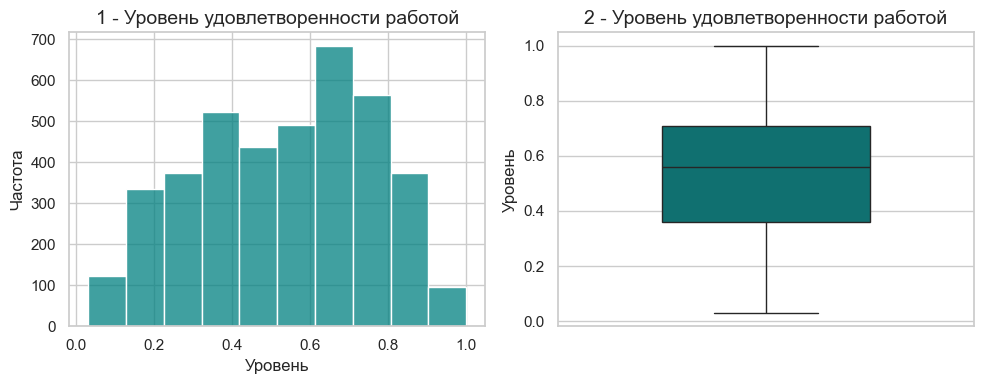

In [21]:
# Графики по столбцу 'job_satisfaction_rate'
plt_hist_boxplt(train_rate, 'job_satisfaction_rate', title='Уровень удовлетворенности работой', 
                 label='Уровень', bins=10, color='teal')

Значения распределены нормально. Средний уровень удовлетворенности работой у сотрудников - **0,53**. 

2) `dept` - отдел, в котором работает сотрудник.

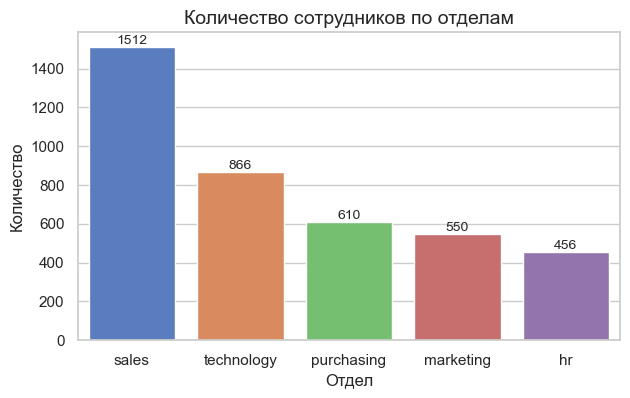

In [22]:
# График по столбцу 'dept'
plt_bar(train_rate, 'dept', xlabel='Отдел',title='Количество сотрудников по отделам', 
        figsize=(7, 4), display_bar_label=True)

Большинство сотрудников (38%) работают в **отделе продаж (sales)**. На втором месте - technology (22%).

3) `level` - уровень занимаемой должности.

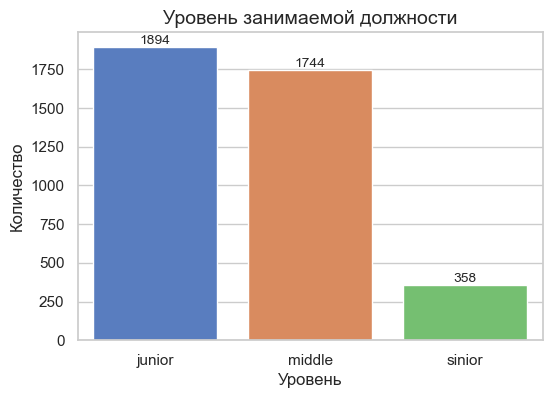

In [23]:
# График по столбцу 'level'
plt_bar(train_rate, 'level', xlabel='Уровень',title='Уровень занимаемой должности', 
        figsize=(6, 4), display_bar_label=True)

Самое большое количество сотрудников имеют уровень **junior** (около 47%). Это может указывать на высокую текучесть кадров, наличие множества начальных позиций или активный набор новых сотрудников. Близко от него располагается уровень middle (44%). Sinior - самая малочисленная группа, всего 9% сотрудников. 

4) `workload` - уровень загруженности сотрудника.

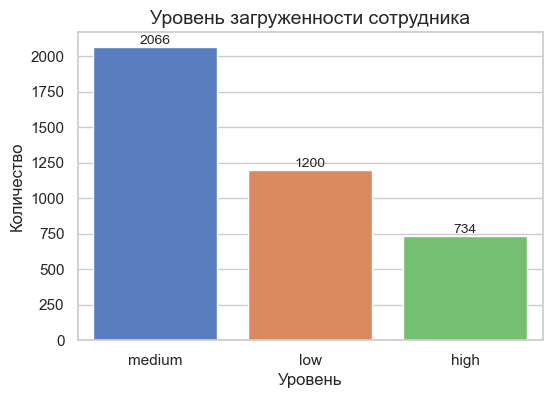

In [24]:
# График по столбцу 'workload'
plt_bar(train_rate, 'workload', xlabel='Уровень',title='Уровень загруженности сотрудника', 
        figsize=(6, 4), display_bar_label=True)

Чуть более половины сотрудников (52%) имеют **средний уровень загруженности**. Это может свидетельствовать о сбалансированности рабочей нагрузки для большинства сотрудников.

Существенное количество сотрудников с низким уровнем загруженности (30%) и достаточно высокий процент (18%) сотрудников с высоким уровнем загруженности может указывать на потенциал для перераспределения задач или улучшения эффективности работы.

5) `employment_years` - длительность работы в компании (в годах).

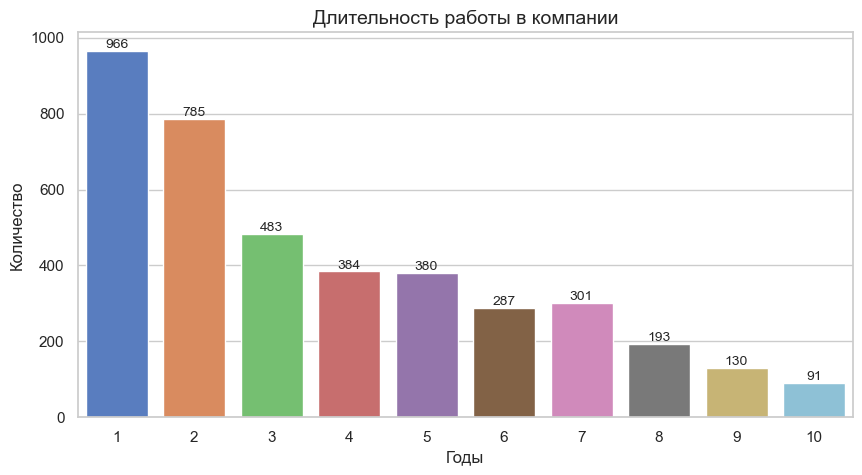

In [25]:
# График по столбцу 'employment_years'
plt_bar(train_rate, 'employment_years', xlabel='Годы',title='Длительность работы в компании', 
        figsize=(10, 5), display_bar_label=True)

Большинство сотрудников находятся в компании **1-2 года** (около 43% всех работников). Начиная с 3 года, количество сотрудников резко уменьшается и далее постепенно сокращается с каждым годом. 

Такое распределение значений можно объяснить высоким уровнем текучести кадров в компании, особенно в первые годы. Однако современные тенденции рынка труда таковы, что для сотрудников сменять место работы каждые несколько лет - естественное событие. Особенно для IT, digital сферы. Сотрудники в постоянном поиске наилучших условий, что и побуждает их не оставаться на одном месте работы.

6) `last_year_promo` -  показывает, было ли повышение за последний год.

,Количество
last_year_promo,
no,3880
yes,120


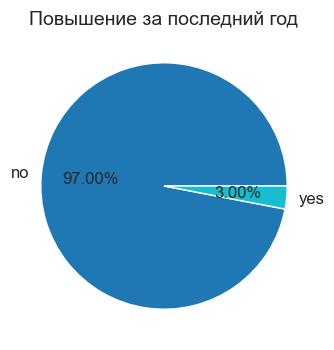

In [26]:
# График по столбцу 'last_year_promo'
plt_pie_pivot(train_rate, 'last_year_promo', 'Повышение за последний год')

Только **3% сотрудников** получили повышение за последний год. Подавляющее большинство сотрудников не получили повышение, что может свидетельствовать о том, что политика повышения в компании либо отсутствует, либо требует пересмотра. Данный факт может оказывать сильное влияние на мотивацию и удовлетворенность сотрудников.

7) `last_year_violations` - показывает, нарушал ли сотрудник трудовой договор за последний год.

,Количество
last_year_violations,
no,3441
yes,559


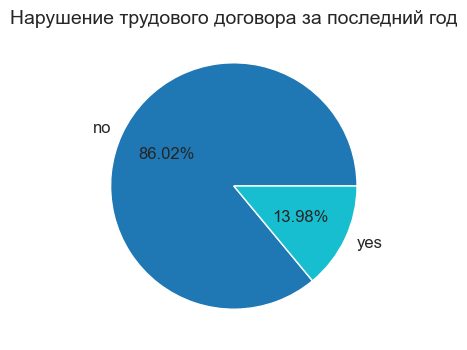

In [27]:
# График по столбцу 'last_year_violations'
plt_pie_pivot(train_rate, 'last_year_violations', 'Нарушение трудового договора за последний год')

Практически **14% сотрудников** нарушали условия трудового договора в течение последнего года. Сотрудники могут быть недовольны условиями работы, что приводит к нарушению условий договора. Также на увеличение числа нарушений может влиять низкий уровень лояльности и мотивации сотрудников.

8) `supervisor_evaluation` - оценка качества работы сотрудника, которую дал руководитель.

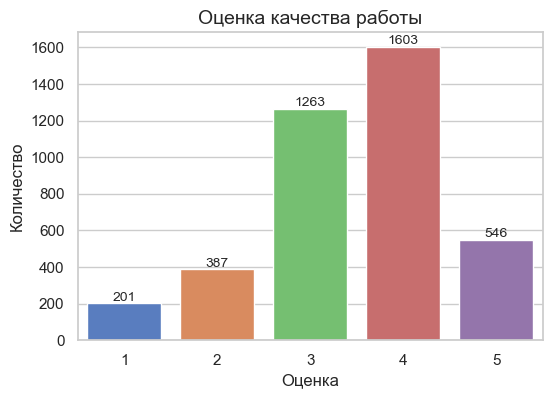

In [28]:
# График по столбцу 'supervisor_evaluation'
plt_bar(train_rate, 'supervisor_evaluation', xlabel='Оценка',title='Оценка качества работы', 
        figsize=(6, 4), display_bar_label=True)

Большинство сотрудников получили оценки **3 либо 4**, что свидетельствует о среднем и выше среднего уровне качества работы. Значительно меньшее количество сотрудников получает крайние оценки (5 и 1), что указывает на редкость как выдающихся, так и очень низких показателей работы.

9) `salary` - ежемесячная зарплата сотрудника.

Описательные статистики параметра Ежемесячная зарплата


,count,mean,std,min,25%,50%,75%,max
salary,4000.000,33926.700,14900.704,12000.000,22800.000,30000.000,43200.000,98400.000


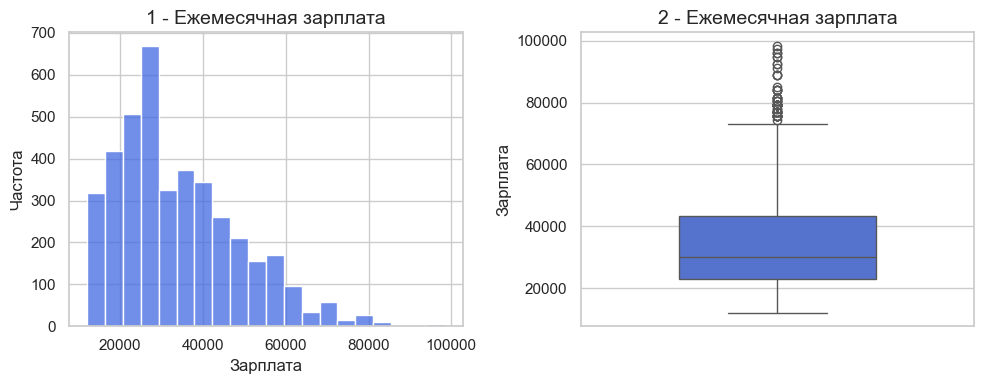

In [29]:
# Графики по столбцу 'salary'
plt_hist_boxplt(train_rate, 'salary', title='Ежемесячная зарплата', 
                 label='Зарплата', bins=20, color='royalblue')

На гистограмме наблюдаем скошенное вправо распределение. Медианное значение зарплаты находится на уровне **30 000**. Около половины сотрудников имеют заработную плату в диапазоне 23 000 - 43 000. 

Значения свыше 75 000 крайне редки и на диаграмме размаха обозначены как выбросы. Рассмотрим детальнее эти значения:

In [30]:
# Срез данных с зарплатой свыше 75000
train_rate.query('salary > 75000') 

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
45,538347,technology,sinior,high,3,no,no,1,84000,0.21
141,128304,marketing,sinior,high,7,no,no,3,80400,0.48
196,486576,marketing,sinior,high,9,no,no,4,76800,0.66
360,405345,marketing,sinior,high,7,no,no,2,81600,0.58
427,399126,sales,sinior,high,2,no,no,2,76800,0.26
1040,301946,hr,sinior,high,7,no,no,5,75600,0.75
1203,493024,technology,sinior,high,10,no,no,4,79200,0.64
1241,148024,technology,sinior,high,4,no,no,4,94800,0.67
1491,796799,marketing,sinior,high,4,no,no,3,79200,0.25
1543,775511,sales,sinior,high,5,no,yes,3,75600,0.17


Сотрудники, имеющие высокую зарплату - это работники уровня sinior, т.е. обладающие значительным опытом и навыками. Также в большинстве своем - из отдела technology. Таким образом, распределение зарплаты логично, ошибок и аномалий не обнаружено. 

#### Зависимость целевого признака от входных признаков

Проанализируем зависимости целевого признака `job_satisfaction_rate` от остальных параметров.

##### Зависимость `job_satisfaction_rate` и количественных переменных

Рассмотрим, зависит ли уровень удовлетворености работой от **заработной платы** сотрудников:

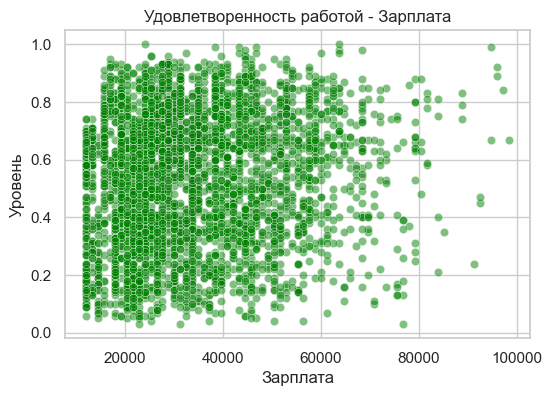

In [31]:
# Диаграмма рассеяния
plt.figure(figsize=(6, 4))
sns.scatterplot(data=train_rate, x='salary', y='job_satisfaction_rate', color='green', alpha=0.5)
plt.title('Удовлетворенность работой - Зарплата')
plt.xlabel('Зарплата')
plt.ylabel('Уровень')
plt.show()

Видим, что точки на графике распределены достаточно равномерно. Линейной зависимости между параметрами не прослеживается, т.е. можем предположить, что уровень зарплаты сотрудника оказывает мало влияния на уровень удовлетворенности работой. Либо зависимость между этими параметрами носит нелинейный характер.

##### Зависимость `job_satisfaction_rate` и категориальных переменных

Проанализируем распределение значений `job_satisfaction_rate`в зависимости от различный категорий.

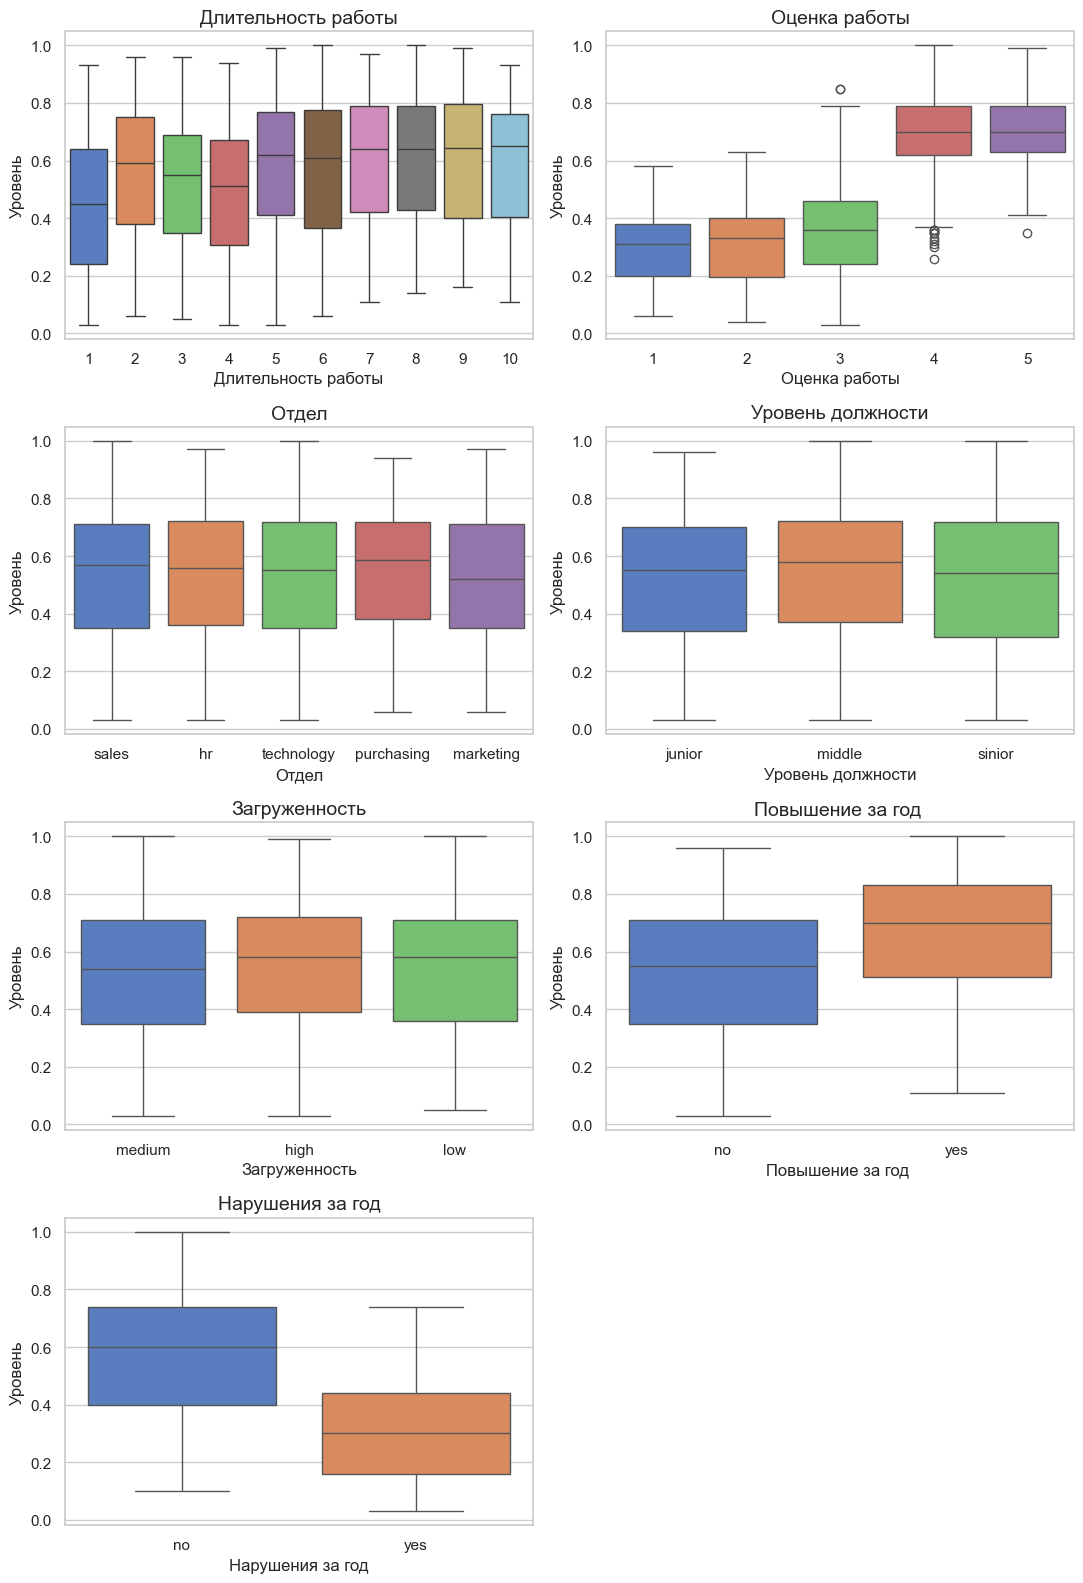

In [32]:
# Диаграммы размаха 'job_satisfaction_rate' по различным категориям
fig, axes = plt.subplots(4, 2, figsize=(11, 16))
axes = axes.flatten()
    
columns = [
    ('Длительность работы', 'employment_years'), 
    ('Оценка работы', 'supervisor_evaluation'), 
    ('Отдел', 'dept'), 
    ('Уровень должности', 'level'),
    ('Загруженность', 'workload'),
    ('Повышение за год ', 'last_year_promo'),
    ('Нарушения за год', 'last_year_violations'),
]
    
for i, (title, col) in enumerate(columns):
    sns.boxplot(data=train_rate, x=col, y='job_satisfaction_rate', ax=axes[i], palette='muted')
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel('Уровень')
   
fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

Распределение значений целевого признака практически не меняется в зависимости от категорий для некоторых признаков, а именно для **отдела, уровня должности и загруженности**. Можно сделать вывод, что они не оказывают значимого влияния на целевой признак.

Для других признаков, распределение `job_satisfaction_rate` различается в зависимости от категорий, что может указывать на зависимость между признаками.

* **`supervisor_evaluation` (Оценка работы)**. Распределение значительно отличается в зависимости от оценки руководителя. Сотрудники, работа которых была оценена в 4 и 5 баллов, имеют в среднем более высокий уровень удовлетворенности (~0,75). Сотрудники с оценкой 1 и 2 балла имеют средний уровень удовлетворенности менее 0,4. Данная зависимость не означает причинно-следственную связь (уровеь удовлетворенности работой может влиять на мотивацию и качество работы: чем меньше уровень, тем меньше желания хорошо трудиться и соответственно ниже оценка).
* **`last_year_promo` (Повышение за последний год)**. Работники, которых повышали в должности за последний год, в среднем имеют более высокий уровень удовлетворенности работой - около 0,7 (без повышения  ~0,55).
* **`last_year_violations` (Нарушения за последний год)**. Сотрудники, нарушавшие за последний год условия трудового договора, имеют средний уровень удовлетворенности 0,3. Сотрудники без нарушений - 0,6.
* **`employment_years` (Длительность работы)**. Сотрудники, работающие в компании около года, показывают самый низкий уровень удовлетворенности работой (~0,45). После 5 лет работы уровень значительно не колебается.

#### Анализ 'test_features' и 'test_target_rate'

Далее мы проанализируем данные тестовой выборки, а именно насколько распределение признаков в тестовой выборке **схоже с распределением в тренировочной**. Это позволит убедиться в согласованности данных между тренировочной и тестовой выборками, выявить возможные проблемы и смещения, и гарантировать, что модель будет корректно работать на новых данных. 

Перед этим объединим датафреймы `test_target_rate` и `test_features` в 1 - **test_rate**.

In [33]:
# Объединение данных тестовой выборки
test_rate = test_features.merge(test_target_rate, on='id')

# Проверка результатов
print('test_features. Количество строк -', test_features.shape[0])
print('test_target_rate. Количество строк -', test_target_rate.shape[0])
print('Количество строк после объединения -', test_rate.shape[0])
print('Количество уникальных id после объединения -', test_rate['id'].nunique())

test_features. Количество строк - 2000
test_target_rate. Количество строк - 2000
Количество строк после объединения - 2000
Количество уникальных id после объединения - 2000


Сравним распределение **количественных параметров** в зависимости от выборки:

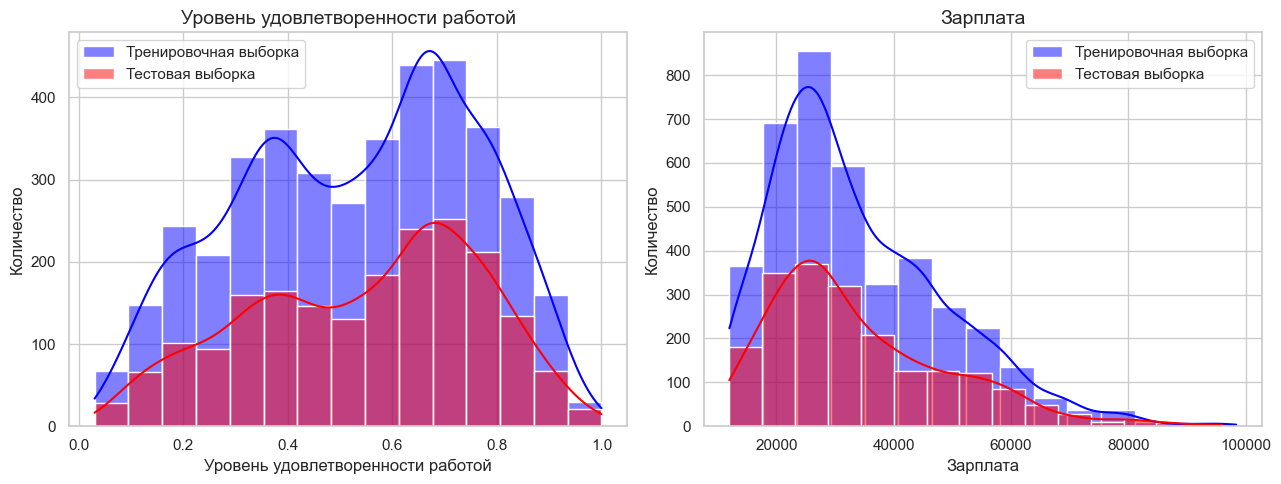

In [34]:
# Диаграммы размаха 'job_satisfaction_rate' по различным категориям
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
columns_num = [
    ('Уровень удовлетворенности работой', 'job_satisfaction_rate'), 
    ('Зарплата', 'salary'), 
]
    
for i, (title, col) in enumerate(columns_num):
    sns.histplot(train_rate[col], bins=15, kde=True, label='Тренировочная выборка', ax=axes[i], color='blue')
    sns.histplot(test_rate[col], bins=15, kde=True, label='Тестовая выборка', ax=axes[i], color='red')
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel('Количество')
    axes[i].legend()

plt.tight_layout()
plt.show()

На гистограммах видим, что распределение значений в тестовой выборке схоже с распределением в тренировочной. Аномальных значений не обнаружено. Также проверим **категориальные признаки**:

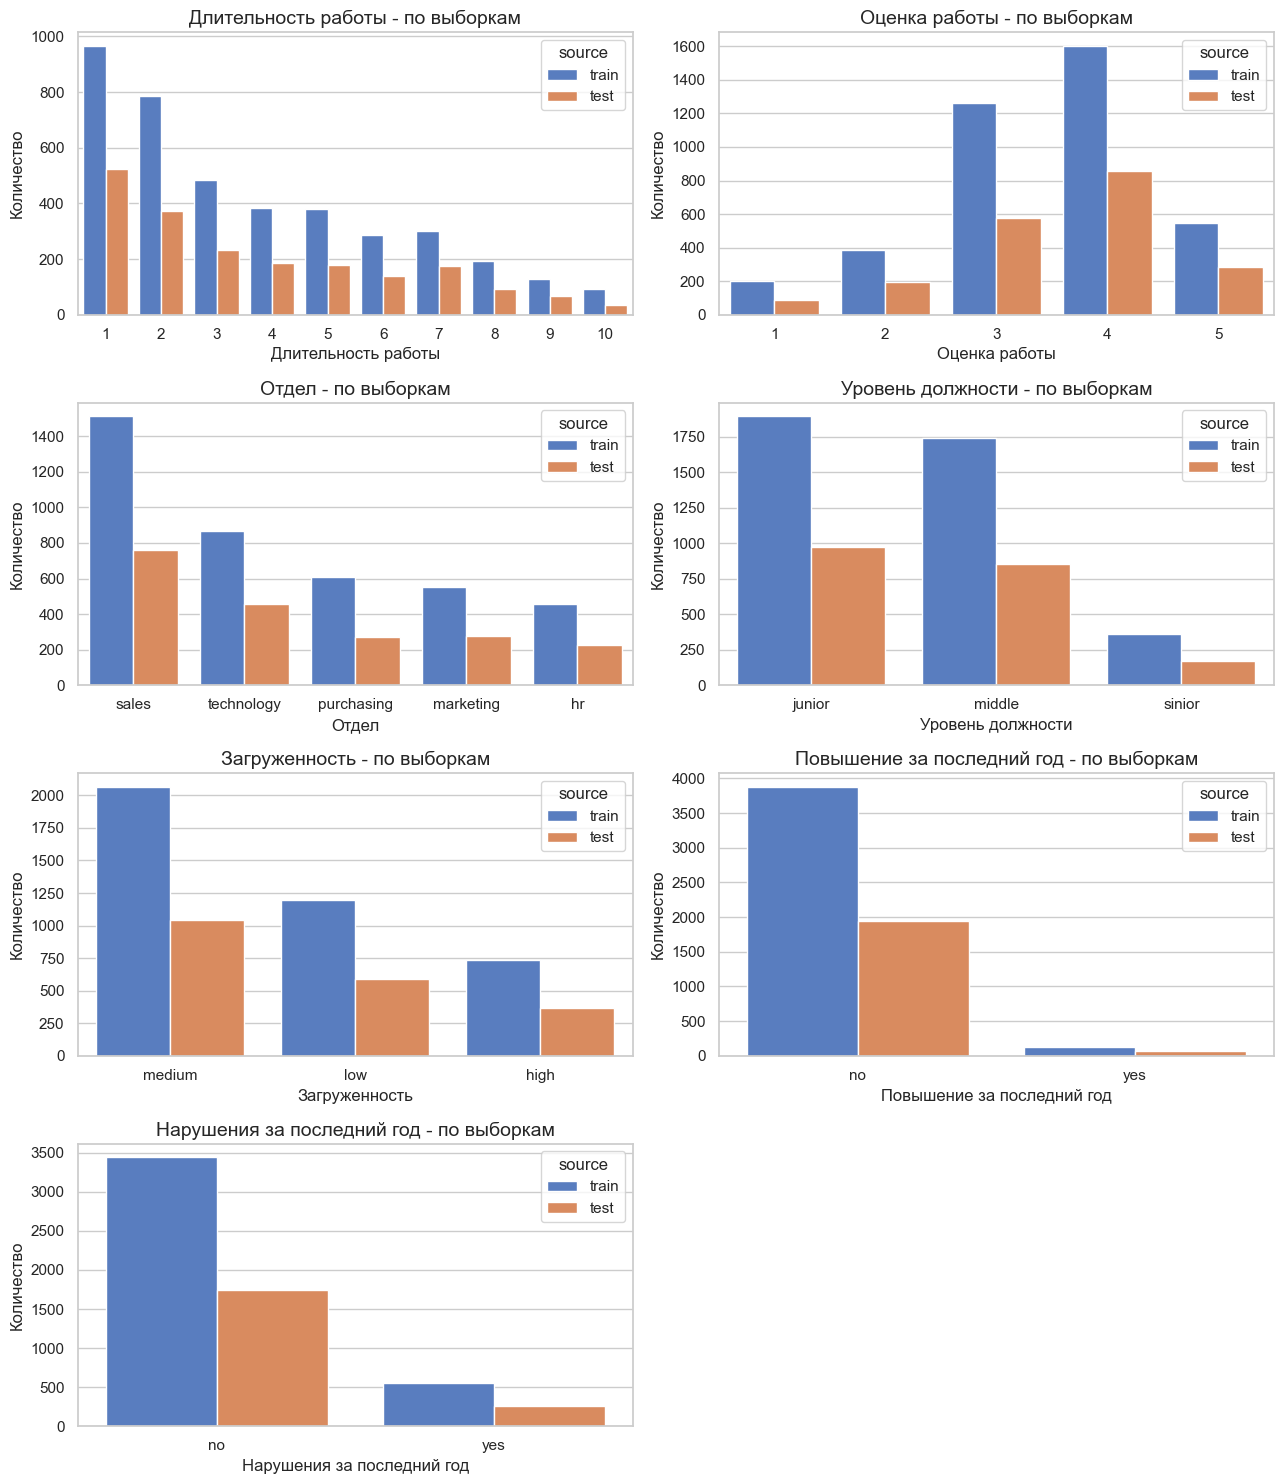

In [35]:
# Подготовка датафреймов
train_rate_for_comb = train_rate.copy()
test_rate_for_comb = test_rate.copy()
train_rate_for_comb['source'] = 'train'
test_rate_for_comb['source'] = 'test'
combined_df = pd.concat([train_rate_for_comb, test_rate_for_comb])

# Столбцы для графиков
columns_barplot = [
    ('Длительность работы', 'employment_years'), 
    ('Оценка работы', 'supervisor_evaluation'), 
    ('Отдел', 'dept'), 
    ('Уровень должности', 'level'),
    ('Загруженность', 'workload'),
    ('Повышение за последний год', 'last_year_promo'), 
    ('Нарушения за последний год', 'last_year_violations')   
]

# Построение графиков
fig, axes = plt.subplots(4, 2, figsize=(13, 15))
axes = axes.flatten()

for i, (title, col) in enumerate(columns_barplot):
    column_pivot_bar = (
        combined_df
        .pivot_table(index=[col, 'source'], values='id', aggfunc='count')
        .reset_index()
        .sort_values(by='id', ascending=False)
    )

    sns.barplot(data=column_pivot_bar, x=col, y='id', hue='source', ax=axes[i], palette='muted')
    axes[i].set_title(f'{title} - по выборкам', fontsize=14)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel('Количество')

fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

Все классы и категории данных в тестовой выборке представлены аналогично тренировочной, таким образом **данные в выборках сбалансированы**. Смещений и аномалий в тестовой выборке не обнаружили.

**Выводы**:

Рассмотрев основные данные о сотрудниках, мы проанализировали распределение значений по каждому параметру. В результате:
* Средний уровень удовлетворенности работой у сотрудников составляет **0,53**.
* Большинство сотрудников (38%) работают в **отделе продаж (sales)**
* Самое большое количество сотрудников имеют уровень **junior** (около 47%).
* Чуть более половины сотрудников (52%) имеют **средний уровень загруженности**. Существенное количество сотрудников с низким уровнем загруженности (30%)
* Большинство сотрудников находятся в компании **1-2 года** (около 43% всех работников).
* Всего **3% сотрудников** получили повышение за последний год.
* Практически **14% сотрудников** нарушали трудовой договор за последний год.
* Большинство сотрудников получили за свою работу оценки **3 либо 4**.
* Медианное значение зарплаты находится на уровне **30 000**.
* Распределение **уровня удовлетворенности работой** наиболее всего различается в зависимости от оценки качества работы, наличия повышений и нарушений за последний год, а также длительности работы в компании.
* Данные в тренировочной и тестовой выборках сбалансированы.

### Корреляционный анализ

Изучим взаимосвязь между признаками. Для этого рассчитаем коэффициенты корреляции Фи и построим тепловую карту. Используем для расчета все количественные и качественные признаки, кроме `id` (его удалим из расчета).

In [36]:
# Установка столбца 'id' в качестве индекса
train_rate.set_index('id', inplace=True)

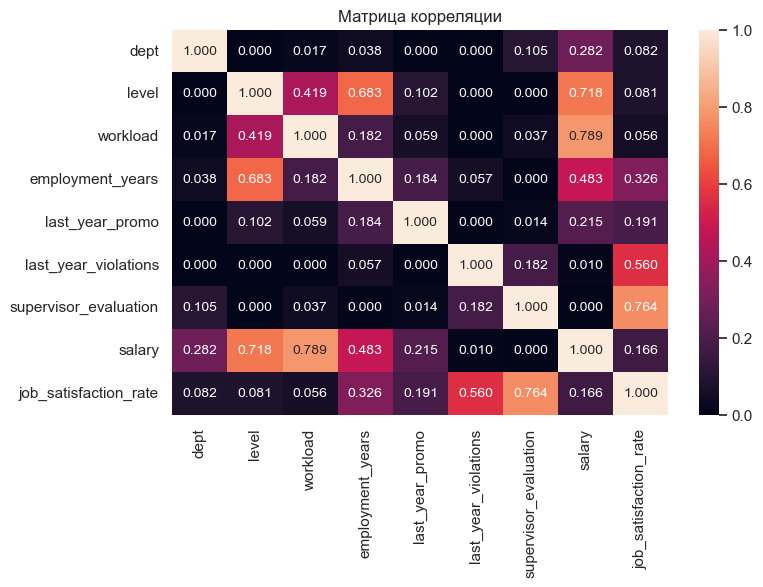

In [37]:
# Матрица корреляции
corr_phik_heatmap(train_rate, 'Матрица корреляции', 
                  df_interval_cols=['salary', 'job_satisfaction_rate'])

**Выводы:**
* Целевой признак **`job_satisfaction_rate`** имеет высокий уровень корреляции с параметром `supervisor_evaluation` - коэффициент 0,764. Также заметна корреляция с `last_year_violations` - 0,56.
* Крайне низкую корреляцию с целевым признаком показали параметры `dept`, `level` и `workload`. Однако удалять их из входных признаков не станем, т.к. отсутствие корреляции не исключет наличия нелинейной взаимосвязи .
* Мультиколлениарности среди входных признаков не наблюдаем (коэффициенты ниже 0,8).

### Подготовка данных 

Для подготовки данных к обучению будем использовать пайплайн. Перед этим разделим данные на выборки, а также создадим списки с названиями столбцов для кодирования и масштабирования.

In [38]:
# Объявление констант
RANDOM_STATE = 42

# Установка столбца 'id' в качестве индекса
test_rate.set_index('id', inplace=True)

# Разделение данных на выборки
X_train = train_rate.drop(['job_satisfaction_rate'], axis=1)
X_test = test_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_rate['job_satisfaction_rate']
y_test = test_rate['job_satisfaction_rate']

# Списки с названиями столбцов для кодирования и масштабирования
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['workload', 'level']
num_columns = ['salary', 'employment_years', 'supervisor_evaluation']

Создадим пайплайн для подготовки данных. 

Для **кодирования** категориальный признаков будем использовать 2 варианта:
* OneHotEncoder()
* OrdinalEncoder() - для работы с ранговыми признаками

Для заполнения пропущенных значений будем использовать **SimpleImputer()** (стратегия - наиболее частое значение).

В качестве скейлеров для **масштабирования** количественных признаков протестируем 3 варианта:
* StandardScaler()
* MinMaxScaler()
* RobustScaler()

In [39]:
def make_pipeline (ohe_columns, ord_columns, num_columns, model):
    '''
    Создает пайплайн на основе предоставленных столбцов и модели.
    Args:
        ohe_columns (list): наименования столбцов для OneHotEncoder.
        ord_columns (list): наименования столбцов для OrdinalEncoder.
        num_columns (list): наименования столбцов для масштабироваия .
        model (str): используемая модель.
    '''
    # Создание пайплайна для ohe кодирования
    ohe_pipe = Pipeline(
        [
            ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]
    )

    # Создание пайплайна для ord кодирования
    ord_pipe = Pipeline(
        [
            ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('ord', OrdinalEncoder(
                categories=[
                    ['low', 'medium', 'high'], 
                    ['junior', 'middle', 'senior']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan)),
            ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ]
    )

    # Создание общего пайплайна для подготовки данных
    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', MinMaxScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

    # Создание итогового пайплайна: подготовка и модель
    pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', model)
        ]
    )

    return pipe_final

In [40]:
# Создание пайплайна
pipeline_regr = make_pipeline(ohe_columns, ord_columns, num_columns, model=LinearRegression())

# Структура готового пайплайна
pipeline_regr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'senior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', MinMaxScaler(),
                                                  ['salary', 'employment_years',
                                                   'supervisor_evaluation'])])),
                ('models', LinearRegression())])

**Выводы:**

Для подготовки данных к последующему обучению модели создали пайплайн. Для заполнения пропущенных значений будет использоваться **SimpleImputer**, для кодирования категориальных признаков - **OneHotEncoder и OrdinalEncoder**; для масштабирования количественных признаков будет протестировано 3 варианта - **StandardScaler, MinMaxScaler, RobustScaler**.

### Обучение моделей

#### Обучение

В качестве метрики для оценки качества модели будет выступать **SMAPE** («симметричное среднее абсолютное процентное отклонение»). Создадим функцию для ее расчета. 

**Критерий успеха: SMAPE ≤15 на тестовой выборке.**

In [41]:
# Функция для расчета SMAPE
def smape(y_true, y_pred):
    return (100/len(y_true)) * ((abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2)).sum())

# Создание метрики для оценки модели
smape_score = make_scorer(smape, greater_is_better=False)

Для поиска лучшей модели протестируем 4 варианта:
* **LinearRegression**
* **Ridge**
* **DecisionTreeRegressor**
* **KNeighborsRegressor.**

Для каждой подберем гиперпараметры, с которыми модель показывает наилучшие результаты. Поиск будем осуществлять через **RandomizedSearchCV**.

In [42]:
# Словаь для поиска гиперпараметров 
param_grid_regr = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }, 

    # словарь для модели Ridge()
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },

     # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,15),
        'models__max_features': range(2, 15),
        'models__min_samples_split': range(2,10),
        'models__min_samples_leaf': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    
    # словарь для модели KNeighborsRegressor()
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2,7),
        'models__leaf_size': range(20, 30),
        'models__metric': ['cityblock', 'minkowski', 'euclidean'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
]

In [43]:
# Случайный поиск гиперпараметров и  модели
random_search_regr = RandomizedSearchCV(
    pipeline_regr, 
    param_grid_regr, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_iter=300,
    n_jobs=-1
)

random_search_regr.fit(X_train, y_train)
y_test_pred = random_search_regr.predict(X_test)

# Результаты
print('Лучшая модель и её параметры:\n\n', random_search_regr.best_estimator_)
print('Метрика SMAPE лучшей модели при кросс-валидации:', (random_search_regr.best_score_)* -1)
print('Метрика SMAPE лучшей модели на тестовой выборке:', smape(y_test, y_test_pred))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                  

Лучшей моделью стала **DecisionTreeRegressor** со следующими параметрами: 
* 'models__min_samples_split': 7,
* 'models__min_samples_leaf': 3,
* 'models__max_features': 10,
* 'models__max_depth': 14

SMAPE при кросс-валидации составила **14.48275624890555**, на тестовой выборке - **13.401683971010744**. 

Таким образом, критерий успеха достигнут (SMAPE ≤15 на тестовой выборке)

Расмотрим также результаты перекрестной проверки для всех выполненных комбинаций параметров:

In [44]:
# Общие результаты поиска randomized_search
pd.DataFrame(random_search_regr.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_features,param_models__max_depth,param_models,...,param_models__leaf_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
279,0.039730,0.003994,0.014851,2.142804e-03,MinMaxScaler(),7.0,3.0,10.0,14.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-15.215327,-14.419381,-14.847671,-14.483941,-13.447461,-14.482756,0.590877,1
102,0.037923,0.002936,0.015454,1.361423e-03,RobustScaler(),7.0,2.0,13.0,14.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': RobustScaler(), 'models_...",-15.466304,-14.908060,-15.160461,-14.647538,-13.414031,-14.719279,0.706703,2
199,0.041537,0.005905,0.029900,2.027002e-02,MinMaxScaler(),8.0,1.0,13.0,13.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-15.250961,-14.891941,-15.331971,-15.043143,-13.331379,-14.769879,0.735696,3
10,0.030098,0.002006,0.011840,9.829181e-04,passthrough,8.0,1.0,12.0,13.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': 'passthrough', 'models__...",-15.250961,-14.876076,-15.331971,-15.041179,-13.473342,-14.794706,0.679735,4
55,0.032707,0.000802,0.012644,4.921795e-04,RobustScaler(),8.0,2.0,14.0,12.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': RobustScaler(), 'models_...",-15.485303,-14.657330,-15.494906,-14.692448,-13.646241,-14.795246,0.680515,5
3,0.033910,0.001603,0.015854,4.275930e-03,StandardScaler(),7.0,2.0,14.0,13.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': StandardScaler(), 'model...",-15.570711,-14.781477,-15.224130,-14.826836,-13.660374,-14.812706,0.643877,6
208,0.044146,0.014801,0.015853,3.320659e-03,passthrough,6.0,2.0,10.0,14.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': 'passthrough', 'models__...",-15.518418,-14.786096,-15.322106,-14.585090,-13.995359,-14.841414,0.542949,7
156,0.039130,0.007094,0.014850,2.142608e-03,MinMaxScaler(),8.0,2.0,10.0,13.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-15.292979,-14.886569,-15.732501,-14.430502,-13.977588,-14.864028,0.618462,8
221,0.035517,0.003455,0.014851,3.774470e-03,passthrough,5.0,4.0,12.0,13.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': 'passthrough', 'models__...",-15.236921,-14.779417,-15.427131,-14.882867,-14.189374,-14.903142,0.426886,9
52,0.030298,0.001947,0.012042,8.971638e-07,passthrough,2.0,5.0,14.0,14.0,DecisionTreeRegressor(random_state=42),...,NaN,"{'preprocessor__num': 'passthrough', 'models__...",-15.368654,-14.745121,-15.654520,-15.148551,-13.742660,-14.931901,0.664688,10


Самые лучшие результаты показала модель DecisionTreeRegressor с разными вариациями гиперпараметров. Дерево решений оказалось более эффективной моделью, чем линейные. Деревья хорошо работают с нелинейными зависимостями между признаками и целевой переменной. Таким образом, дерево решений смогло уловить в наших данных сложные нелинейные отношения, в то время как линейные модели не могут этого сделать.

#### Анализ важности признаков

Далее проаназируем важность признаков для модели. Удаление менее значимых признаков может повысить метрику качества модели. Для анализа будем использовать **SHAP** (метод Explainer).

In [45]:
# Извлечение модели из результатов randomized_search
best_reg_model = random_search_regr.best_estimator_.named_steps['models']

# Преобразование выборок с входными признаками
X_train_transform = random_search_regr.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_test_transform = random_search_regr.best_estimator_.named_steps['preprocessor'].transform(X_test)

# Извлечение названий ohe столбцов
ohe_columns_transform = (
    random_search_regr
    .best_estimator_.named_steps['preprocessor']
    .named_transformers_['ohe'].named_steps['ohe']
    .get_feature_names_out(ohe_columns)
)

# Список всех названий столбцов
feature_names = np.hstack([ohe_columns_transform, ord_columns, num_columns])

# Преобразование в датафреймы
X_train_df = pd.DataFrame(X_train_transform, columns=feature_names)
X_test_df = pd.DataFrame(X_test_transform, columns=feature_names)

# Выычисление значений SHAP
explainer = shap.Explainer(best_reg_model, X_train_df)
shap_values = explainer(X_test_df)

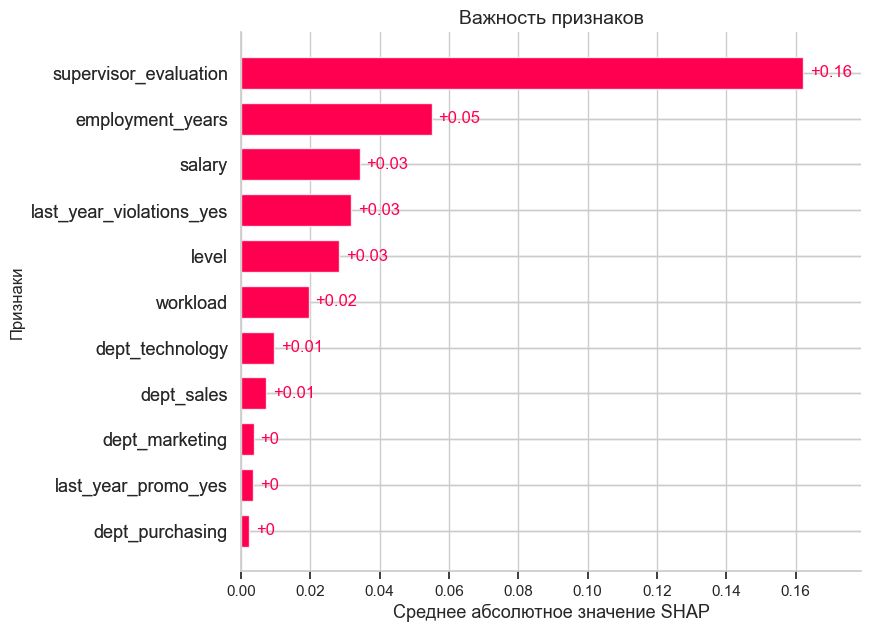

In [46]:
# График важности признаков
shap.plots.bar(shap_values, max_display=20, show=False)
plt.title('Важность признаков', fontsize=14)
plt.xlabel('Среднее абсолютное значение SHAP')
plt.ylabel('Признаки')
plt.show()

* Признаками, которые сильнее всего влияют на целевой являются `supervisor_evaluation` (самое большое влияние на предсказания модели), `employment_years` и `salary`.
* Наименьшее влияние на целевой признак оказывают `dept`, `last_year_promo`.

Попробуем **удалить наименее важные** для модели признаки и проверим, как это скажется на метрике качества:

In [47]:
# Разделение данных на выборки с удалением неважных признаков
X_train_1 = train_rate.drop(['job_satisfaction_rate', 
                             'last_year_promo', 'dept'], axis=1)
X_test_1 = test_rate.drop(['job_satisfaction_rate', 
                           'last_year_promo', 'dept'], axis=1)

# Списки с названиями столбцов для кодирования и масштабирования
ohe_columns_1 = ['last_year_violations']
ord_columns_1 = ['workload', 'level']
num_columns_1 = ['salary', 'employment_years', 'supervisor_evaluation']

# Создание пайплайна
pipeline_regr_1 = make_pipeline(ohe_columns_1, ord_columns_1, num_columns_1, 
                                model=LinearRegression())

# Случайный поиск гиперпараметров и  модели
random_search_1 = RandomizedSearchCV(
    pipeline_regr_1, 
    param_grid_regr, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_iter=300,
    n_jobs=-1
)

random_search_1.fit(X_train_1, y_train)
y_test_pred_1 = random_search_1.predict(X_test_1)

# Результаты
print('Метрика SMAPE лучшей модели при кросс-валидации:', (random_search_1.best_score_)* -1)
print('Метрика SMAPE лучшей модели на тестовой выборке:', smape(y_test, y_test_pred_1))

Метрика SMAPE лучшей модели при кросс-валидации: 16.55364019177604
Метрика SMAPE лучшей модели на тестовой выборке: 15.688622888854969


После удаления признаков `dept`, `last_year_promo` SMAPE увеличилось на 17% на тестовой выборки и составило **15.688622888854969**. Таким образом, удаление признаков лишь ухудшило качество модели. В дальнейшем будем использовать первоначальный вариант модели DecisionTreeRegressor со всеми входными признаками.

### Промежуточный вывод по разделу 1

1) Для выбора наилучшей модели в рамках исследования были протестированы 4 различных варианта: LinearRegression, Ridge, DecisionTreeRegressor,  и KNeighborsRegressor. Каждая модель была настроена с использованием различных гиперпараметров, а также в процессе подготовки данных были применены два различных кодера и три метода масштабирования признаков.

2) Наилучшую метрику качества продемонстрировала модель **DecisionTreeRegressor** со следующими параметрами: 
* 'models__min_samples_split': 7,
* 'models__min_samples_leaf': 3,
* 'models__max_features': 10,
* 'models__max_depth': 14

Значение метрики SMAPE для этой модели при кросс-валидации составило **14.48275624890555**, на тестовой выборке - **13.401683971010744**. Критерий успеха достигнут.

3) В результате анализа важности признаков с помощью SHAP, мы выявили признаки, которые сильнее всего влияют на целевой:`supervisor_evaluation`, `employment_years` и `salary`.

4) Протестировали модель без наименее важных признаков (`dept`, `last_year_promo`), но после этого качество ухудшилось на 17%. Таким образом, наилучшее качество модель показывает со всеми входными признаками.

## Раздел 2: Предсказание увольнения сотрудника из компании

### Загрузка и обзор данных

In [48]:
# Загрузка данных
try:
    train_quit = pd.read_csv('train_quit.csv')
    test_target_quit = pd.read_csv('test_target_quit.csv')
    print('Данные успешно загружены')
except:
    print('Ошибка при загрузке')

Данные успешно загружены


Входные признаки тестовой выборки находятся в датафрейме **test_features**, который был загружен и исследован в Разделе 1.

In [49]:
# Вывод общей информации о датафрейме `train_quit`
data_info(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary
count,4000.000,4000.000,4000.000,4000.000
mean,552099.284,3.702,3.475,33805.800
std,260158.031,2.542,1.004,15152.415
min,100222.000,1.000,1.000,12000.000
25%,327785.750,2.000,3.000,22800.000
50%,546673.000,3.000,4.000,30000.000
75%,781497.750,6.000,4.000,43200.000
max,999915.000,10.000,5.000,96000.000


In [50]:
# Вывод общей информации о датафрейме `test_target_quit`
data_info(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id
count,2000.000
mean,552765.214
std,253851.326
min,100298.000
25%,339052.000
50%,550793.000
75%,765763.750
max,999029.000


**Общая предварительная оценка данных:**
- Набор данных достаточен для исследовательского анализа.
- Данные разделены на 3 датафрейма: **train_quit** содержит 4000 строк тренировочной выборки с характеристиками сотрудников и увольнением сотрудника из компании; **test_features** мы изучили ранее (в разделе 1); **test_target_quit** содержит 2000 строк тестовой выборки с целевым признаком - увольнение сотрудника.
- В данных могут содержатся дубликаты.

Для дальнейшей работы с данными выполним предобработку.

### Предобработка данных

#### Исследование пропусков

In [51]:
# Словарь с датафреймами
all_df_quit = {
    'train_quit': train_quit,
    'test_target_quit': test_target_quit
}

In [52]:
# Подсчет количества пропусков
for name, df in all_df_quit.items():
    print(f'Количество пропущенных значений в {name}:\n', df.isna().sum(), '\n')

Количество пропущенных значений в train_quit:
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64 

Количество пропущенных значений в test_target_quit:
 id      0
quit    0
dtype: int64 



Пропущенных значений не обнаружено.

#### Обработка дубликатов

##### Обработка явных дубликатов

In [53]:
# Подсчет количества явных дубликатов
for name, df in all_df_quit.items():
    print(f'Количество явных дубликатов в {name}:', df.duplicated().sum())

Количество явных дубликатов в train_quit: 0
Количество явных дубликатов в test_target_quit: 0


Явных дубликатов ни в одном из датафреймов не обнаружили.

##### Обработка неявных дубликатов

Также проверим наличие неявных дубликатов в столбцах с категориальными значениями.

In [54]:
# Уникальные значения категориальных столбцов 'train_quit'
category_col_unique(train_quit)

Уникальные значения в столбце - dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в столбце - level: ['middle' 'junior' 'sinior']
Уникальные значения в столбце - workload: ['high' 'medium' 'low']
Уникальные значения в столбце - last_year_promo: ['no' 'yes']
Уникальные значения в столбце - last_year_violations: ['no' 'yes']
Уникальные значения в столбце - quit: ['no' 'yes']


Неявных дубликатов также не обнаружили.

**В результате предобработки данных**:

* Были проверены пропущенные значения, их не обнаружили.
* Были проверены явные и неявные дубликаты, их не обнаружили. 

### Исследовательский анализ данных

#### Анализ параметров 'train_quit' в разрезе целевого признака

Столбцы и количество строк в датафрейме **train_quit** совпадают с изученным ранее **train_rate** (за исключением целевого признака). Проверим, различаются ли распределения значений. Параметры изучим с разрезе целевого признака `quit`.

1) `quit` - увольнение сотрудника из компании. Целевой признак.

,Количество
quit,
no,2872
yes,1128


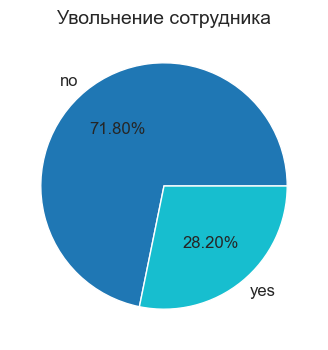

In [55]:
# График по столбцу 'quit'
plt_pie_pivot(train_quit, 'quit', 'Увольнение сотрудника')

Количество уволившихся сотрудников в датасете составляет чуть более **28%**. В признаке наблюдается дисбаланс классов. Учтем этот факт и протестируем вариант модели с использованием Oversampling.

2) `dept` - отдел, в котором работает сотрудник.

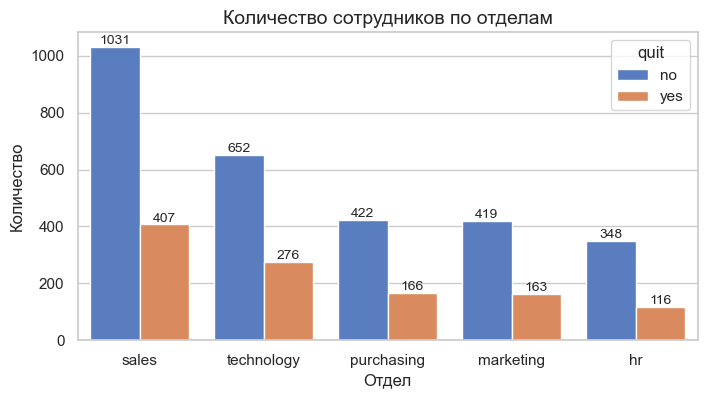

In [56]:
# График по столбцу 'dept'
plt_bar_hue(train_quit, 'dept', hue='quit', xlabel='Отдел',title='Количество сотрудников по отделам', 
        figsize=(8, 4), display_bar_label=True)

- *Общее распределение*. В целом распределение значений совпадает с ранее изученным датасетом (train_rate). Наибольшее количество работников находится в **отделе продаж**.
- *В разрезе целевого признака* различий в распределении также не наблюдаем. Таким образом, можем предположить, что увольнение сотрудника практически не зависит от отдела, в котором он работал. Наибольшее количество ушедших сотрудников приходится на **отдел продаж (sales)**.

3) `level` - уровень занимаемой должности.

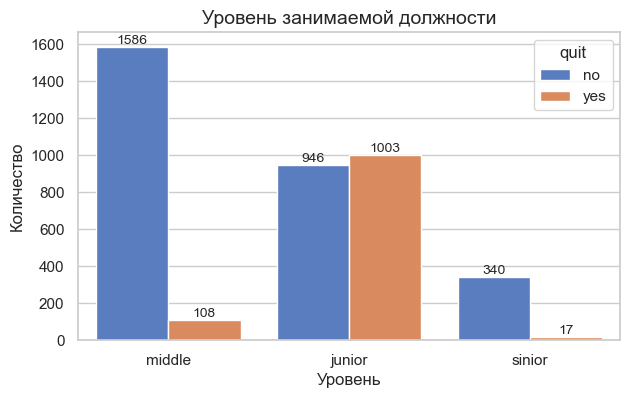

In [57]:
# График по столбцу 'level'
plt_bar_hue(train_quit, 'level', hue='quit', xlabel='Уровень',
            title='Уровень занимаемой должности', figsize=(7, 4), display_bar_label=True)

- *Общее распределение*. Самое большое количество сотрудников имеют уровень **junior** (практически 49%).
- *В разрезе целевого признака*. Самое большое количество уволившихся сотрудников занимали должность уровня **junior**. Количество уволившихся сотрудников практически равно количеству оставшихся. Это указывает на высокую текучесть кадров именно на младшем уровне должности. Возможно, молодые специалисты либо не видят перспектив роста, либо переходят на более привлекательные позиции в других компаниях. Количество уволившихся сотрудников уровней middle и sinior значительно меньше по сравнению с оставшимися.

4) `workload` - уровень загруженности сотрудника.

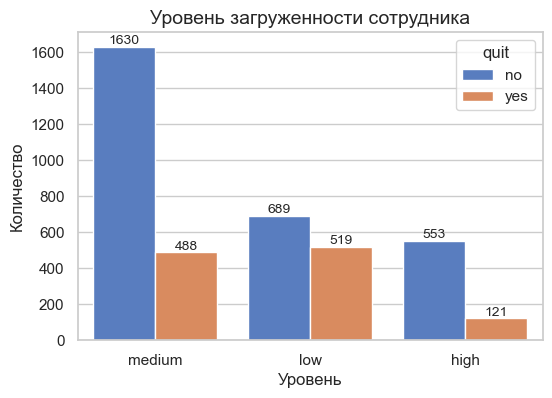

In [58]:
# График по столбцу 'workload'
plt_bar_hue(train_quit, 'workload', hue='quit', xlabel='Уровень',
            title='Уровень загруженности сотрудника', figsize=(6, 4), display_bar_label=True)

- *Общее распределение*. Чуть более половины сотрудников (52%) имеют **средний уровень загруженности**.
- *В разрезе целевого признака.* Наибольшее количество уволившихся работников имели **низкий уровеь загруженности**. Число ушедших и оставшихся сотрудников близко друг к другу. Недостаток рабочих задач не позволяет сотрудику развиваться и обучаться, поэтому они более склонны к уходу из компании.

5) `employment_years` - длительность работы в компании (в годах).

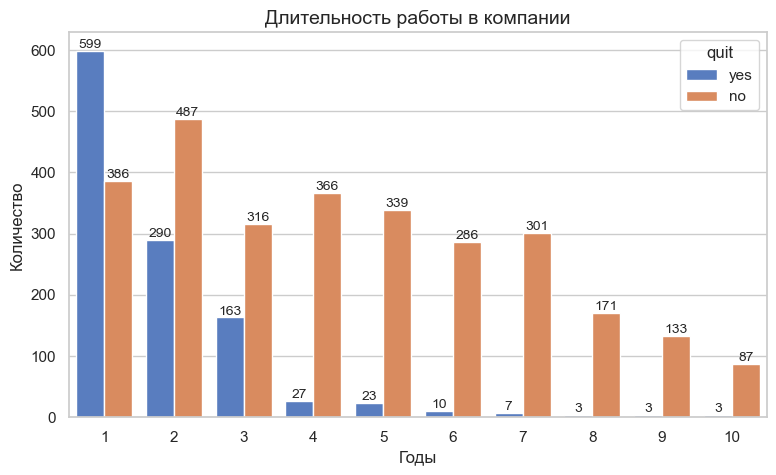

In [59]:
# График по столбцу 'employment_years'
plt_bar_hue(train_quit, 'employment_years', hue='quit', xlabel='Годы',title='Длительность работы в компании', 
        figsize=(9, 5), display_bar_label=True)

- *Общее распределение*. Большинство сотрудников находятся в компании **1-2 года** (около 43% всех работников).
- *В разрезе целевого признака.* Подавляющее количество уволившихся сотрудников покидают компанию в **1-ый год работы.** Спустя 3 года количество увольнений значительно сокращается.

6) `last_year_promo` -  показывает, было ли повышение за последний год.

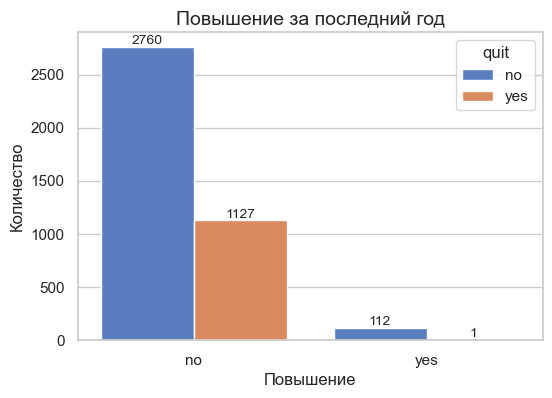

In [60]:
# График по столбцу 'last_year_promo'
plt_bar_hue(train_quit, 'last_year_promo', hue='quit', xlabel='Повышение',
            title='Повышение за последний год', figsize=(6, 4), display_bar_label=True)

- *Общее распределение*. За последний год всего **3% сотрудников** получили повышение.
- *В разрезе целевого признака.* Наибольший процент уволившихся сотрудников **не получали повышение** в течение последнего года.

7) `last_year_violations` - показывает, нарушал ли сотрудник трудовой договор за последний год.

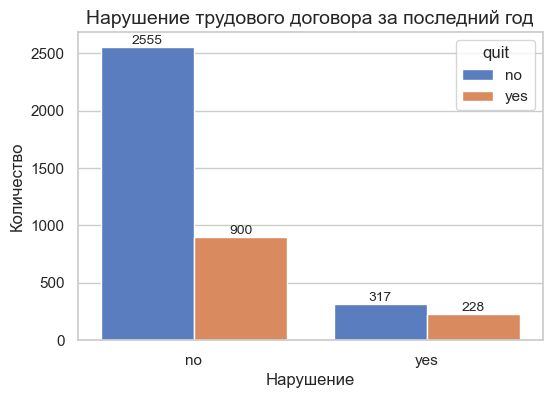

In [61]:
# График по столбцу 'last_year_violations'
plt_bar_hue(train_quit, 'last_year_violations', hue='quit', xlabel='Нарушение',
            title='Нарушение трудового договора за последний год', figsize=(6, 4), 
            display_bar_label=True)

- *Общее распределение*. За последний год **13% сотрудников** нарушали условия трудового договора.
- *В разрезе целевого признака.* Из всех сотрудников, **нарушавших трудовой договор**, около 41% уволилось. Из сотрудников, которые не нарушали условий, процент уволившихся составляет 26%. Таким образом, для нарушителей условий договора вероятность ухода из компании намного выше. 

8) `supervisor_evaluation` - оценка качества работы сотрудника, которую дал руководитель.

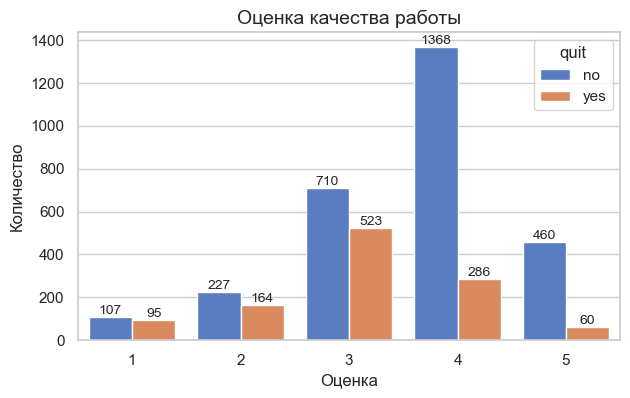

In [62]:
# График по столбцу 'supervisor_evaluation'
plt_bar_hue(train_quit, 'supervisor_evaluation', hue='quit', xlabel='Оценка',
            title='Оценка качества работы', figsize=(7, 4), display_bar_label=True)

- *Общее распределение*. Работа большинства сотрудников оценена рководителем в **3 либо 4** балла.
- *В разрезе целевого признака.* Ушедшие сотрудники чаще оставшихся получали низкую и среднюю оценку свой работы **(1-3 бала)** Количество уволившихся сотрудников с оценкой 1 практически равно количеству оставшихся. А при оценке работы в 4 и 5 баллов процент увольнений значительно сокращается. 

9) `salary` - ежемесячная зарплата сотрудника.

Описательные статистики параметра Ежемесячная зарплата


,count,mean,std,min,25%,50%,75%,max
salary,4000.000,33805.800,15152.415,12000.000,22800.000,30000.000,43200.000,96000.000


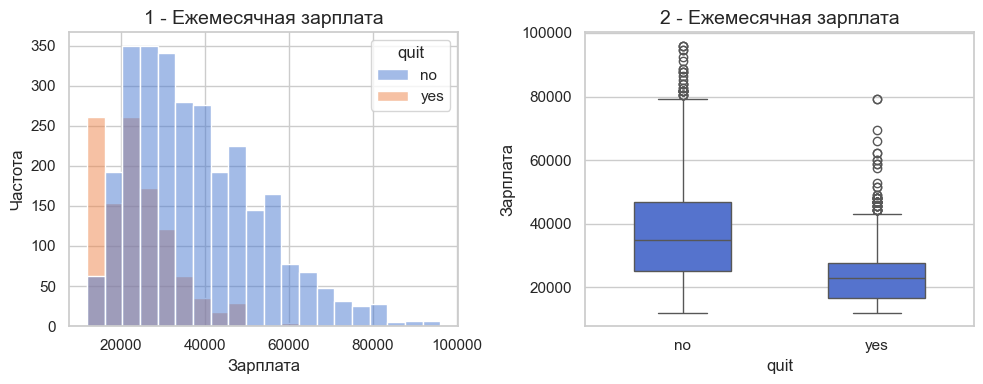

In [63]:
# Графики по столбцу 'salary'
plt_hist_boxplt(train_quit, 'salary', title='Ежемесячная зарплата', hue='quit',
                 label='Зарплата', bins=20, color='royalblue')

- *Общее распределение*. Медианное значение зарплаты составляет **30000.**
- *В разрезе целевого признака.* Заработная плата уволившихся сотрудников в среднем была ниже, чем у остальных работников, и составляла **23000**. У оставшихся работников она составляет около 350000. Следует отметить, что большинство уволившихся - специалисты уровя junior, поэтому вполне логично, что зарплата у них ниже, чем у работников более высокого звена.

Также отдельно рассмотрим процентное распределение значений в параметрах для уволившихся сотрудников. Для этого из датафрейма 'train_quit' выделим ушедших сотрудников ('train_quit_yes').

In [64]:
# Датафрейм с уволившимися сотрудниками
train_quit_yes = train_quit.query('quit == "yes"')
print('Количество уволившихся сотрудников -', train_quit_yes.shape[0])

Количество уволившихся сотрудников - 1128


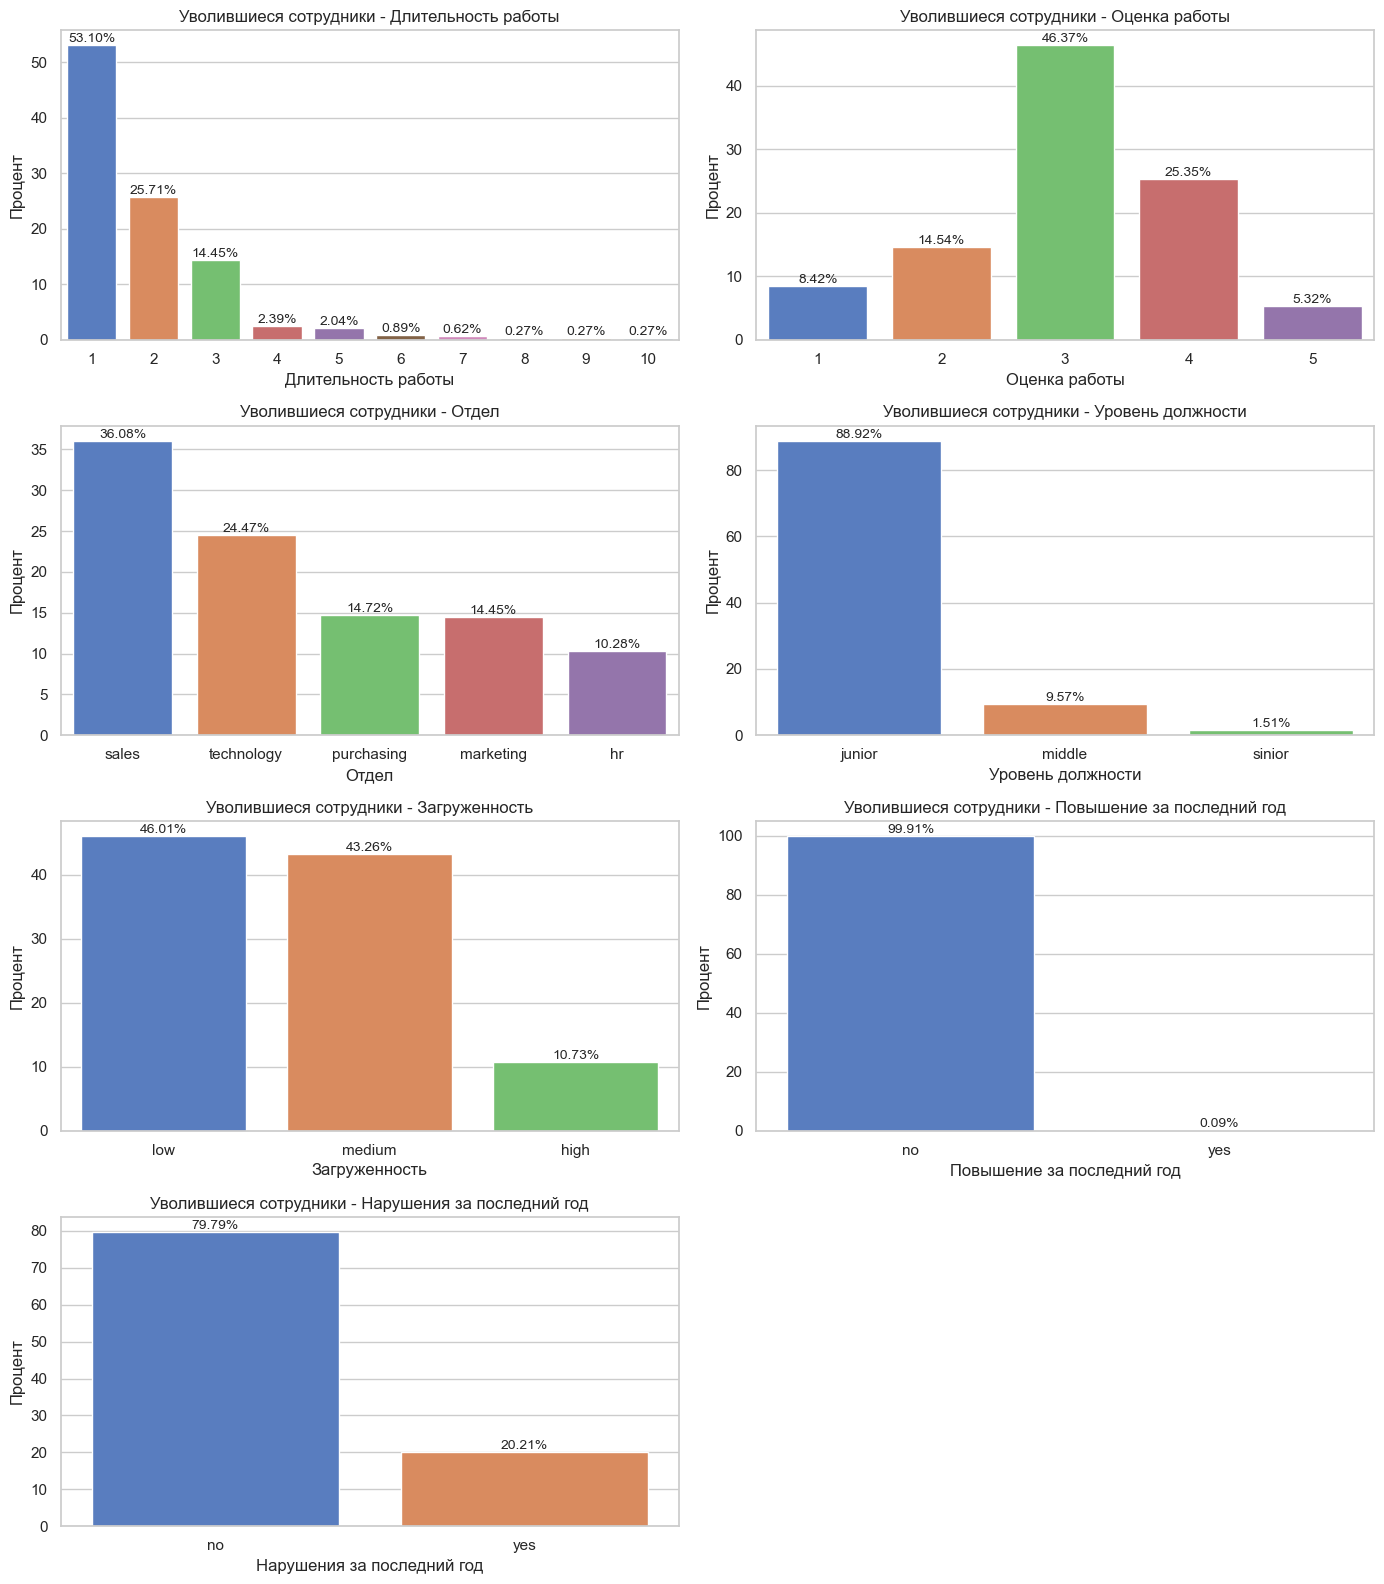

In [65]:
# Столбцы для построения графика
columns_barplot = [
    ('Длительность работы', 'employment_years'), 
    ('Оценка работы', 'supervisor_evaluation'), 
    ('Отдел', 'dept'), 
    ('Уровень должности', 'level'),
    ('Загруженность', 'workload'),
    ('Повышение за последний год', 'last_year_promo'), 
    ('Нарушения за последний год', 'last_year_violations')   
]

# Построение графиков
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

train_quit_yes_count = train_quit_yes['id'].count()

for i, (title, col) in enumerate(columns_barplot):
    column_pivot_bar = (
        train_quit_yes
        .pivot_table(index=[col], values='id', aggfunc='count')
        .reset_index()
        .sort_values(by='id', ascending=False)
    )
    
    # Расчет процентного соотношения
    column_pivot_bar['percent'] = column_pivot_bar['id'] / train_quit_yes_count * 100

    # Столбчатая диаграмма
    sns.barplot(data=column_pivot_bar, x=col, y='percent', ax=axes[i], palette='muted')
    axes[i].set_title(f'Уволившиеся сотрудники - {title}', fontsize=12)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel('Процент')

    # Добавление меток на столбики
    for container in axes[i].containers:
        axes[i].bar_label(container, labels=[f'{h.get_height():.2f}%' for h in container], fontsize=10)

fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

***
Исходя из рассмотренных данных мы можем составить **портрет «уволившегося сотрудника»**:
* Наиболее вероятно, что сотрудник занимает должность уровня **junior**. 89% от всего количества уволившихся - специалисты младшего звена.
* Уволившиеся сотрудники чаще всего имели **низкий уровень загруженности**.
* Большинство сотрудников покидает компанию в **первый год работы**. Также не редки уходы во 2 и 3 годы.
* Наибольший процент уволившихся сотрудников **не получали повышение** в течение последнего года.
* Сотрудники, **нарушавшие трудовой договор**, имеют более высокий процент увольнений (41%) по сравнению с теми, кто не нарушал условия договора (26%).
* Уволившиеся сотрудники чаще получали **низкую и среднюю оценку** своей работы (1-3 балла).
* Средняя заработная плата уволившихся сотрудников составляла **23,000**, что на 52% ниже, чем средняя зарплата оставшихся работников. 

#### Зависимость увольнения от уровня удовлетворенности работой

Проверим гипотезу, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Для этого объединим датафреймы 'test_target_quit' и 'test_target_rate'.

In [66]:
# Датафрейм с 2 целевыми признаками
test_both_target = test_target_quit.merge(test_target_rate, on='id')
test_both_target.set_index('id', inplace=True)

# Проверка результатов
print('test_target_quit. Количество строк -', test_target_quit.shape[0])
print('test_target_rate. Количество строк -', test_target_rate.shape[0])
print('Количество строк после объединения -', test_both_target.shape[0])
print('Количество уникальных id после объединения -', test_both_target.index.nunique())
test_both_target.head()

test_target_quit. Количество строк - 2000
test_target_rate. Количество строк - 2000
Количество строк после объединения - 2000
Количество уникальных id после объединения - 2000


,quit,job_satisfaction_rate
id,,
999029,yes,0.35
372846,no,0.21
726767,no,0.73
490105,no,0.62
416898,yes,0.57


Далее проанализируем график плотности `job_satisfaction_rate` в разрезе `quit`, а также построим матрицу корреляции.

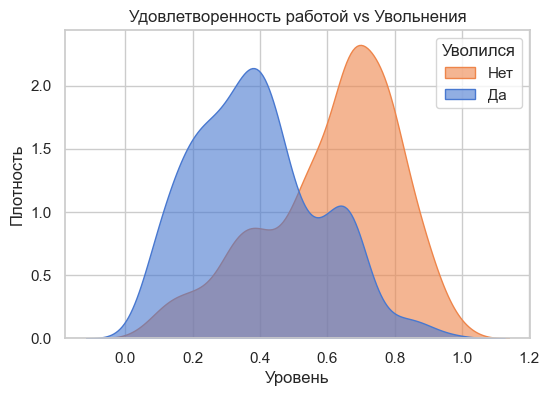

In [67]:
# График плотости по столбцу 'job_satisfaction_rate'
plt.figure(figsize=(6, 4))
sns.kdeplot(data=test_both_target, x='job_satisfaction_rate', hue='quit', 
            fill=True, common_norm=False, alpha=0.6, linewidth=1)

plt.title('Удовлетворенность работой vs Увольнения')
plt.xlabel('Уровень')
plt.ylabel('Плотность')
plt.legend(title='Уволился', labels=['Нет', 'Да'])
plt.grid(True)
plt.show()

Распределение значений сильно оличается. Средний уровень удовлетворенности работой уволившихся людей составляет **0.37**, у оставшихся сотрудников - 0.66, что на 78% больше. Таким образом, большинство сотрудников, которые ушли из компании, имели относительно низкий уровень удовлетворенности работой.

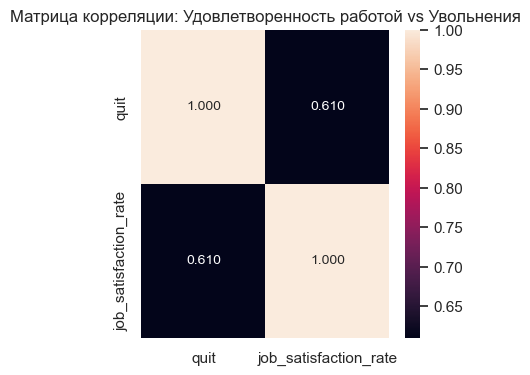

In [68]:
# Матрица корреляции
corr_phik_heatmap(test_both_target, 'Матрица корреляции: Удовлетворенность работой vs Увольнения', 
                  figsize=(4,4), df_interval_cols=['job_satisfaction_rate'])

Коэффициент корреляции между признаками составляет **0,61**, что говорит о наличии заметной взаимосвязи между увольнением и уровнем удовлетворенности. Таким образом, будет эффективно использовать параметр `job_satisfaction_rate` при обучении модели на предсказание `quit`.

**Выводы**:

Рассмотрев основные данные о сотрудниках, мы проанализировали распределение значений по каждому параметру. В результате:
* Общее распределение значений входных признаков координально не отличается от рассмотренного ранее 'train_rate' в разделе 1.
* Мы составили обобщенный **портрет уволившегося сотрудника**. Уволившийся сотрудник с высокой вероятностью занимал должность уровня junior, имел низкий уровень загруженности, не получал повышение в последний год, нарушал условия трудового договора, получал низкие или средние оценки своей работы и получал заработную плату ниже средней по компании.
* Обнаружили взаимосвязь целевого признака `quit` (увольнение) и признака `job_satisfaction_rate` (уровень удовлетворенности) - коэффициент корреляции **0,61**.

### Добавление нового входного признака

Т.к. `job_satisfaction_rate` и `quit` действительно взаимосвязаны, добавим к входным признакам `job_satisfaction_rate`, предсказанный лучшей моделью в разделе 1. 

In [69]:
# Отделение целевого признака в отдельный датафрейм 
train_quit_target = train_quit[['quit', 'id']]
train_quit_target.set_index('id', inplace=True)

# Создание датафрейма без целевого признака
train_quit_no_target = train_quit.drop('quit', axis=1)
train_quit_no_target.set_index('id', inplace=True)

train_quit_no_target.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000
814010,sales,junior,medium,2,no,no,4,27600
155091,purchasing,middle,medium,5,no,no,1,37200
257132,sales,junior,medium,2,no,yes,3,24000
910140,marketing,junior,medium,2,no,no,5,25200


С помощью модели DecisionTreeRegressor, обученной в разделе 1, предскажем уровень удовлетворенности работой. Добавим эти значения в тренировочную выборку.

In [70]:
# Добавление предсказания в тренировочную выборку
train_quit_no_target['job_satisfaction_rate'] = (
    random_search_regr
    .predict(train_quit_no_target)
    .round(2)
)

train_quit_no_target.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.64
814010,sales,junior,medium,2,no,no,4,27600,0.83
155091,purchasing,middle,medium,5,no,no,1,37200,0.33
257132,sales,junior,medium,2,no,yes,3,24000,0.35
910140,marketing,junior,medium,2,no,no,5,25200,0.79


Вернем целевой признак `quit` в тренировочную выборку. А также добавим его в тестовую выборку.

In [71]:
# Добавление целевого признака 'quit' в тринирочоную выборку
train_rate_quit = train_quit_no_target.join(train_quit_target)
train_rate_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.64,no
814010,sales,junior,medium,2,no,no,4,27600,0.83,no
155091,purchasing,middle,medium,5,no,no,1,37200,0.33,no
257132,sales,junior,medium,2,no,yes,3,24000,0.35,yes
910140,marketing,junior,medium,2,no,no,5,25200,0.79,no


In [72]:
# Добавление целевого признака 'quit' в тестовую выборку
test_rate_quit = test_rate.join(test_target_quit.set_index('id'))
test_rate_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


**Выводы:**

* С помощью модели DecisionTreeRegressor, обученной в разделе 1, мы рассчитали `job_satisfaction_rate` и добавили эти значения в тренировочную выборку.
* Также подготовили датафрейм тестовой выборки: объединили входные признаки, параметр `job_satisfaction_rate` и целевой признак `quit`.

### Корреляционный анализ

Изучим взаимосвязь между признаками. Для этого рассчитаем коэффициенты корреляции Фи и построим тепловую карту. Используем для расчета все количественные и качественные признаки.

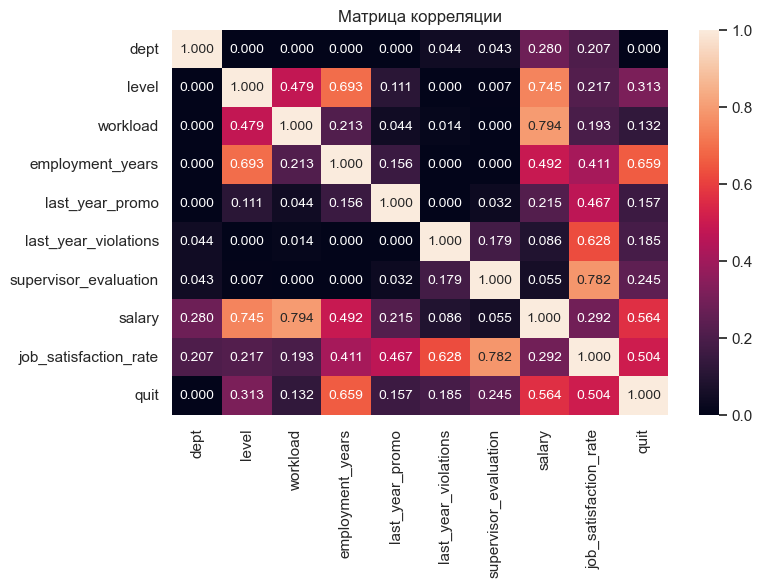

In [73]:
# Матрица корреляции
corr_phik_heatmap(train_rate_quit, 'Матрица корреляции',
                 df_interval_cols=['salary', 'job_satisfaction_rate'])

* Целевой признак **`quit`** имеет заметный уровень корреляции с параметрами `employment_years`(коэффициент 0,659), `job_satisfaction_rate` (коэффициент 0,504), `salary` (0,564).
* Нулевую корреляцию с целевым признаком показал параметр `dept`. Однако удалять его из входных признаков не станем, т.к. отсутствие корреляции не исключет наличия нелинейной взаимосвязи.
* Мультиколлениарности среди входных признаков не наблюдаем (коэффициенты ниже 0,8).

Построим отдельные матрицы корреляции в зависимости от значения целевого признака - для уволившихся и оставшихся сотрудников.

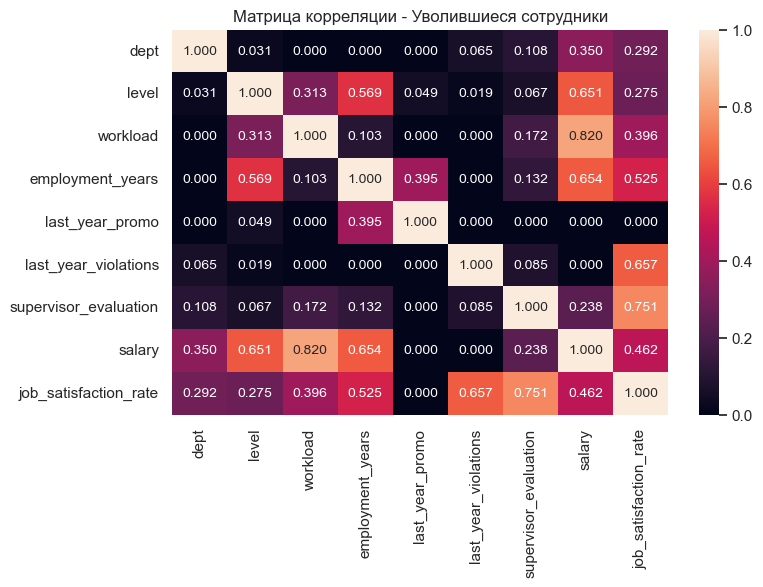

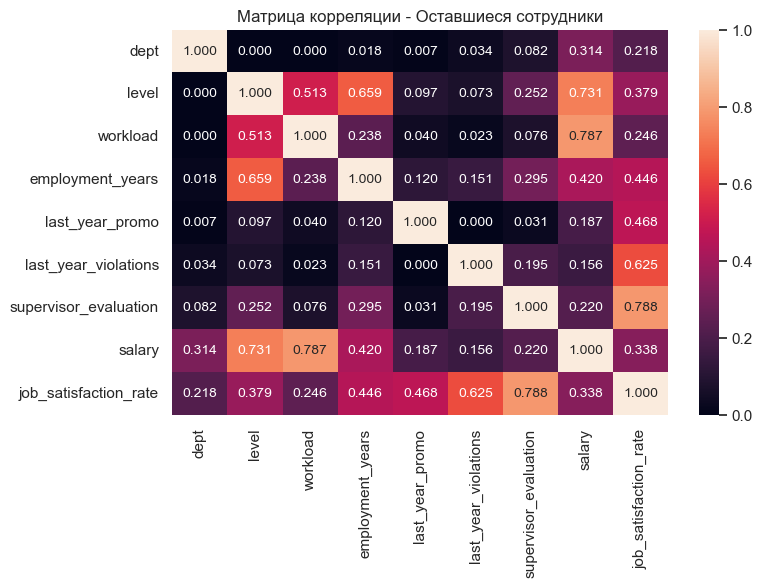

In [74]:
# Срезы данных по целевому признаку
train_rate_quit_yes = train_rate_quit.query('quit == "yes"')
train_rate_quit_no = train_rate_quit.query('quit == "no"')

# Матрицы корреляции
corr_phik_heatmap(train_rate_quit_yes, 'Матрица корреляции - Уволившиеся сотрудники',
                 df_interval_cols=['salary', 'job_satisfaction_rate'])
corr_phik_heatmap(train_rate_quit_no, 'Матрица корреляции - Оставшиеся сотрудники',
                 df_interval_cols=['salary', 'job_satisfaction_rate'])

Значительной разницы в корреляции в разбивке по таргету не наблюдается.

**Выводы:**

Проанализировав матрицу корреляции, выявили следующие взаимосвязи:
* Высокая корреляция целевого признака `quit` с параметрами `employment_years`(0,659), `job_satisfaction_rate` (0,504), `salary` (0,564).
* Нулевая корреляция с параметром `dept`, но он не удаляется из-за возможной нелинейной взаимосвязи.
* Отсутствие мультиколлинеарности среди входных признаков (все коэффициенты корреляции ниже 0,8).

### Подготовка данных 

Для подготовки данных к обучению будем использовать созданный ранее пайплайн. Перед этим разделим данные на выборки, а также создадим списки с названиями столбцов для кодирования и масштабирования.

Преобразуем целевой признак `quit` в бинарный категориальный с помощью **LabelEncoder()**

In [75]:
# Объявление констант
RANDOM_STATE = 42

# Разделение данных на выборки
X_train_cl = train_rate_quit.drop(['quit'], axis=1)
X_test_cl = test_rate_quit.drop(['quit'], axis=1)
y_train_cl = train_rate_quit['quit']
y_test_cl = test_rate_quit['quit']

# Кодирование целевого признака
target_classes = ['yes', 'no']

le_encoder = LabelEncoder()
le_encoder.classes = np.array(target_classes)
le_encoder.fit(y_train_cl)

y_train_cl = le_encoder.transform(y_train_cl)
y_test_cl = le_encoder.transform(y_test_cl)

# Списки с названиями столбцов для кодирования и масштабирования
ohe_columns_cl = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns_cl = ['workload', 'level']
num_columns_cl = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate']

Создадим пайплайн для подготовки данных. 

Для **кодирования** категориальный признаков будем использовать 2 варианта:
* OneHotEncoder()
* OrdinalEncoder() - для работы с ранговыми признаками

Для заполнения пропущенных значений будем использовать **SimpleImputer()** (стратегия - наиболее частое значение).

В качестве скейлеров для **масштабирования** количественных признаков протестируем 3 варианта:
* StandardScaler()
* MinMaxScaler()
* RobustScaler()

In [76]:
# Создание пайплайна
pipeline_class = make_pipeline(ohe_columns_cl, ord_columns_cl, num_columns_cl, 
                               DecisionTreeClassifier(random_state=RANDOM_STATE))

# Структура готового пайплайна
pipeline_class

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_befor...
                                                                                               'medium',
                                                                                               'high'],
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'senior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['workload', 'level']),
                                                 ('num', MinMaxScaler(),
                                                  ['salary', 'employment_years',
                                                   'supervisor_evaluation',
                                                   'job_satisfaction_rate'])])),
                ('models', DecisionTreeClassifier(random_state=42))])

**Выводы:**

Для подготовки данных к последующему обучению модели создали пайплайн. Для заполнения пропущенных значений будет использоваться **SimpleImputer**, для кодирования категориальных признаков - **OneHotEncoder и OrdinalEncoder**; для кодирования целевого признака - **LabelEncoder**; для масштабирования количественных признаков будет протестировано 3 варианта - **StandardScaler, MinMaxScaler, RobustScaler**.

### Обучение моделей

#### Обучение

В качестве метрики для оценки качества модели будет выступать ROC-AUC. 
**Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке.** 

Для поиска лучшей модели протестируем 4 варианта:
* **LogisticRegression**
* **DecisionTreeClassifier**
* **KNeighborsClassifier**
* **SVC**

Для каждой подберем гиперпараметры, с которыми модель показывает наилучшие результаты. Поиск будем осуществлять через **RandomizedSearchCV**.

In [77]:
param_grid_class = [
    # Словарь для модели DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10),
        'models__max_features': range(2, 10),
        'models__min_samples_split': range(2,10),
        'models__min_samples_leaf': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },  

    # Словарь для модели KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(10, 50),
        'models__metric': ['cityblock', 'minkowski', 'euclidean'],
        'models__weights': ['uniform', 'distance'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # Словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, solver='liblinear', penalty='l1'
        )],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # Словарь для модели SVC
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': range(1,5),
        'models__gamma': np.logspace(-1, 2, 60), 
        'models__kernel': ['linear', 'rbf', 'poly'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    }
]

In [78]:
# Случайный поиск гиперпараметров и  модели
random_search_class = RandomizedSearchCV(
    pipeline_class, 
    param_grid_class, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search_class.fit(X_train_cl, y_train_cl)
y_test_pred_cl = random_search_class.predict(X_test_cl)
y_test_proba_cl = random_search_class.predict_proba(X_test_cl)[:, 1]

# Результаты
print('Лучшая модель и её параметры:\n\n', random_search_class.best_estimator_)
print ('Метрика ROC-AUC лучшей модели при кросс-валидации:', random_search_class.best_score_)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_cl, y_test_proba_cl)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                  

Лучшей моделью стала **DecisionTreeClassifier** со следующими параметрами: 
* 'models__min_samples_split': 6,
* 'models__min_samples_leaf': 8,
* 'models__max_features': 8,
* 'models__max_depth': 8

ROC-AUC при кросс-валидации составила **0.9322761668690287**, на тестовой выборке - **0.9231303957012189**. 

Таким образом, критерий успеха достигнут (ROC-AUC ≥0.91 на тестовой выборке)

Расмотрим также результаты перекрестной проверки для всех выполненных комбинаций параметров:

In [79]:
# Общие результаты поиска random_search_class
pd.DataFrame(random_search_class.cv_results_).sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.030901,0.001838,0.018863,0.006294,passthrough,6,8,8,8,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",0.925809,0.933697,0.924100,0.924416,0.953359,0.932276,0.011108,1
9,0.026685,0.001361,0.012442,0.001023,passthrough,2,5,9,6,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",0.924850,0.929805,0.913566,0.926455,0.941291,0.927194,0.008914,2
4,0.029496,0.000803,0.014449,0.001022,StandardScaler(),7,2,9,6,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",0.920912,0.928796,0.910098,0.929755,0.934480,0.924808,0.008550,3
6,0.029295,0.000402,0.013447,0.000492,RobustScaler(),6,5,4,9,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models_...",0.922396,0.915362,0.899217,0.916700,0.940420,0.918819,0.013267,4
3,0.028694,0.001501,0.015452,0.002585,StandardScaler(),9,5,3,7,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",0.922311,0.907378,0.910695,0.915763,0.926413,0.916512,0.007064,5
8,0.027689,0.002065,0.013246,0.000984,passthrough,7,1,4,8,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",0.901631,0.906010,0.895320,0.933536,0.932141,0.913727,0.015976,6
5,0.028292,0.001474,0.013245,0.000402,MinMaxScaler(),8,7,7,4,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",0.902338,0.900344,0.911042,0.895736,0.920134,0.905919,0.008671,7
7,0.029095,0.000001,0.013646,0.000492,RobustScaler(),4,4,9,3,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models_...",0.893766,0.892058,0.899406,0.883113,0.910726,0.895814,0.009109,8
2,0.033913,0.008234,0.014046,0.001099,RobustScaler(),5,7,4,4,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': RobustScaler(), 'models_...",0.896394,0.886937,0.883884,0.886663,0.909361,0.892648,0.009366,9
1,0.028897,0.003668,0.013444,0.000491,StandardScaler(),9,9,4,2,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",0.836881,0.834922,0.836010,0.839671,0.853030,0.840103,0.006653,10


Самые лучшие результаты показала модель DecisionTreeClassifier с разными вариациями гиперпараметров. Дерево решений оказалось более эффективной моделью, чем другие. 

#### Анализ матрицы ошибок. Oversampling

Проанализируем матрицу ошибок и рассчитаем метрики Recall и Precision.

Recall = 0.7925531914893617
Precision = 0.8922155688622755


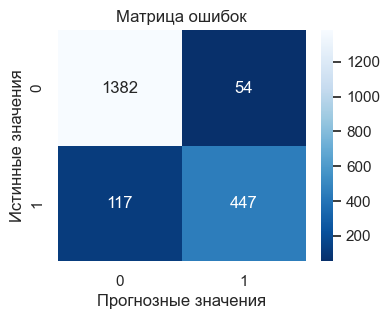

In [80]:
# Матрица ошибок. Расчет Recall и Precision.
classification_quality(y_test_cl, y_test_pred_cl)

* **Recall** = 0.7925531914893617 означает, что модель правильно классифицирует около 79.3% всех положительных примеров. Однако оставшиеся 20.7% положительных примеров классифицируются неправильно (ложноотрицательные).
* **Precision** = 0.8922155688622755 означает, что около 89.2% всех предсказанных положительных примеров действительно являются положительными, что говорит о низком количестве ложноположительных.

Для заказчика предсказание оттока — одна из важнейших задач. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. Поэтому важно **минимизировать ложноотрицательные значения** (когда сотрудник намерен уволиться, а модель предскала обратное). Т.к. в целевом признаке наблюдается дисбаланс классов, а интересующий наш класс - минорный (те, кто уволился), предполагаем именно поэтому модели сложнее верно класифицировать положительный класс. 

Для решения проблемы дисбаланса проведем Oversampling с помощью **SMOTENC** и проверим, как это скажется на метриках качества модели.

In [81]:
X_train_cl.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.64


In [82]:
# Индексы категориальных признаков
index = [0,1,2,4,5]

# Создание экземпляра сэмплера
sampler = SMOTENC(categorical_features=index, random_state=RANDOM_STATE, k_neighbors=5)

# Сэмплирование данных
X_train_resample, y_train_resample = sampler.fit_resample(X_train_cl, y_train_cl)

# Проверка сэпмлирования
print('Распределение классов до сэпмлирования:', np.unique(y_train_cl, return_counts=True))
print('Распределение классов после сэпмлирования:', np.unique(y_train_resample, return_counts=True))

Распределение классов до сэпмлирования: (array([0, 1]), array([2872, 1128], dtype=int64))
Распределение классов после сэпмлирования: (array([0, 1]), array([2872, 2872], dtype=int64))


In [83]:
# Случайный поиск гиперпараметров и  модели
random_search_resample = RandomizedSearchCV(
    pipeline_class, 
    param_grid_class, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search_resample.fit(X_train_resample, y_train_resample)
y_test_pred_cl_resample = random_search_resample.predict(X_test_cl)
y_test_proba_cl_resample = random_search_resample.predict_proba(X_test_cl)[:, 1]

# Результаты
print('Лучшая модель и её параметры:\n\n', random_search_resample.best_estimator_)
print ('Метрика ROC-AUC лучшей модели при кросс-валидации:', random_search_resample.best_score_)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_cl, y_test_proba_cl_resample)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'dept']),
                                  

Recall = 0.8936170212765957
Precision = 0.717948717948718


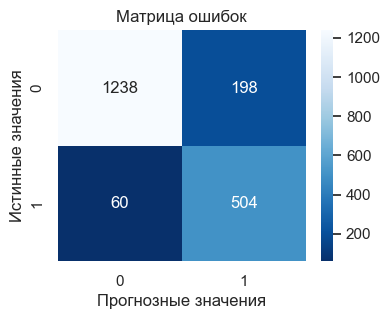

In [84]:
# Матрица ошибок. Расчет Recall и Precision.
classification_quality(y_test_cl, y_test_pred_cl_resample)

После применения SMOTENC:
* **ROC-AUC** на тестовой выборке снизился на 0,19% до **0.9213863618404157**. 
* **Recall** вырос на 11,3% до **0.8936170212765957**. На матрице ошибок видим, что количество ложноотрицательных результатов снизилось практически вдвое. 
* **Precision**  снизился  на 19,5% до **0.717948717948718**. На матрице ошибок наблюдаем, количество ложноположительных увеличилось в 3,5 раз.

Таким образом, использование Oversampling позволило снизить количество ложноотрицательных результатов в 2 раза. Следует отметить, что с ростом Recall снизился Precision (увеличилось количество ложноположительных результатов). Но т.к. для заказчика приоритетным является не упустить сотрудников, собирающихся уволиться, снижение метрики Precision является оправданным шагом.

Критерий успеха ROC-AUC также достигнут.

#### Анализ важности признаков

Далее проаназируем важность признаков для модели. Удаление менее значимых признаков может повысить метрику качества модели. Для анализа будем использовать **SHAP** (метод TreeExplainer).

In [85]:
# Получение лучшей модели из RandomizedSearchCV
best_class_model = random_search_resample.best_estimator_.named_steps['models']

# Преобразование выборок с входными признаками
X_train_transform_cl = random_search_resample.best_estimator_.named_steps['preprocessor'].transform(X_train_resample)
X_test_transform_cl = random_search_resample.best_estimator_.named_steps['preprocessor'].transform(X_test_cl)

# Извлечение названий ohe столбцов
ohe_columns_cl_transform = (
    random_search_resample
    .best_estimator_.named_steps['preprocessor']
    .named_transformers_['ohe'].named_steps['ohe']
    .get_feature_names_out(ohe_columns)
)

# Список всех названий столбцов
feature_names_cl = np.hstack([ohe_columns_cl_transform, ord_columns_cl, num_columns_cl])

X_train_cl_df = pd.DataFrame(X_train_transform_cl, columns=feature_names_cl)
X_test_cl_df = pd.DataFrame(X_test_transform_cl, columns=feature_names_cl)

# Выычисление значений SHAP
explainer_cl = shap.TreeExplainer(best_class_model)
shap_values_cl = explainer_cl(X_test_cl_df)
shap_values_positive_class = shap_values_cl[:, :, 1]

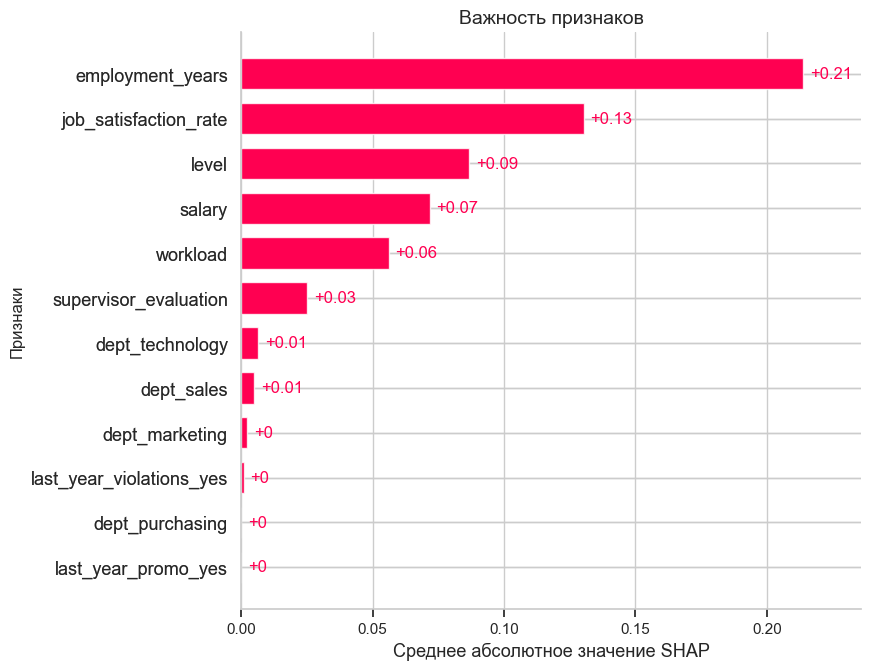

In [86]:
# График важности признаков
shap.plots.bar(shap_values_positive_class, max_display=20, show=False)
plt.title('Важность признаков', fontsize=14)
plt.xlabel('Среднее абсолютное значение SHAP')
plt.ylabel('Признаки')
plt.show()

* Признаками, которые сильнее всего влияют на целевой являются `employment_years` (самое большое влияние на предсказания модели), `job_satisfaction_rate`, `salary` и `level`.
* Наименьшее влияние на целевой признак оказывают `dept`, `last_year_promo` и `last_year_violations`.

Попробуем **удалить наименее важные** для модели признаки и проверим, как это скажется на метрике качества:

In [87]:
# Разделение данных на выборки
X_train_cl_1 = train_rate_quit.drop(['quit', 'last_year_promo', 'dept', 'last_year_violations'], axis=1)
X_test_cl_1 = test_rate_quit.drop(['quit', 'last_year_promo', 'dept', 'last_year_violations'], axis=1)

# Индексы категориальных признаков
index_1 = [0,1,2,4,5]

# Создание экземпляра сэмплера
sampler_1 = SMOTENC(categorical_features=index_1, random_state=RANDOM_STATE, k_neighbors=5)

# Сэмплирование данных
X_train_resample_1, y_train_resample_1 = sampler_1.fit_resample(X_train_cl_1, y_train_cl)

# Списки с названиями столбцов для кодирования и масштабирования
ohe_columns_cl_1 = []
ord_columns_cl_1 = ['workload', 'level']
num_columns_cl_1 = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate']

# Создание пайплайна
pipeline_class_1 = make_pipeline(ohe_columns_cl_1, ord_columns_cl_1, num_columns_cl_1, 
                               DecisionTreeClassifier(random_state=RANDOM_STATE))

# Случайный поиск гиперпараметров и  модели
random_search_class_1 = RandomizedSearchCV(
    pipeline_class_1, 
    param_grid_class, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search_class_1.fit(X_train_resample_1, y_train_resample_1)
y_test_pred_cl_1 = random_search_class_1.predict(X_test_cl_1)
y_test_proba_cl_1 = random_search_class_1.predict_proba(X_test_cl_1)[:, 1]

# Результаты
print('Лучшая модель и её параметры:\n\n', random_search_class_1.best_estimator_)
print ('Метрика ROC-AUC лучшей модели при кросс-валидации:', random_search_class_1.best_score_)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_cl, y_test_proba_cl_1)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  []),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                 

После удаления признаков `dept`, `last_year_promo` и `last_year_violations` ROC-AUC снизился на 5,9% на тестовой выборке и составил **0.866484793259448**. Таким образом, удаление признаков не улучшило качество модели, а лишь ухудшило. Для дальнейшего использования будет использоваться первоначальный вариант модели DecisionTreeClassifier со всеми входными признаками.

**Выводы**:
* Для выбора наилучшей модели в рамках исследования были протестированы четыре различных варианта: LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier и SVC. Каждая модель была настроена с использованием различных гиперпараметров, а также в процессе подготовки данных были применены два различных кодера и три метода масштабирования признаков.
* Для решения проблемы дисбаланса классов и минимизации ложноотрицательных результатов использовался Oversampling - **метод SMOTENC**.
* Наилучшую метрику качества продемонстрировала модель **DecisionTreeRegressor**. Значение метрики ROC-AUC для этой модели при кросс-валидации составило **0.9505400401269579**, на тестовой выборке - **0.9213863618404157**. Критерий успеха достигнут.
* В результате анализа важности признаков с помощью SHAP, мы выявили признаки, которые сильнее всего влияют на целевой:`employment_years`, `job_satisfaction_rate`, `salary` и `level`.
* Протестировали модель без наименее важных признаков (`dept`, `last_year_promo` и `last_year_violations`), но после этого качество ухудшилось на 5,9%. Таким образом, наилучшее качество модель показывает со всеми входными признаками.

### Промежуточный вывод по разделу 2

1)  Для выбора наилучшей модели в рамках исследования были протестированы 4 различных варианта: LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier и SVC. Каждая модель была настроена с использованием различных гиперпараметров, а также в процессе подготовки данных были применены два различных кодера и три метода масштабирования признаков.

2) Для решения проблемы дисбаланса классов использовался Oversampling - **метод SMOTENC**. Его использование позволило минимизировать ложноотрицательные результаты. 

3) Наилучшую метрику качества продемонстрировала модель **DecisionTreeRegressor** со следующими параметрами: 
* 'models__min_samples_split': 6,
* 'models__min_samples_leaf': 8,
* 'models__max_features': 8,
* 'models__max_depth': 8

Значение метрики ROC-AUC для этой модели при кросс-валидации составило **0.9505400401269579**, на тестовой выборке - **0.9213863618404157**. Критерий успеха достигнут.

4) В результате анализа важности признаков с помощью SHAP, мы выявили признаки, которые сильнее всего влияют на целевой:`employment_years`, `job_satisfaction_rate`, `salary` и `level`.

5) Протестировали модель без наименее важных признаков (`dept`, `last_year_promo` и `last_year_violations`), но после этого качество ухудшилось на 5,9%. Таким образом, наилучшее качество модель показывает со всеми входными признаками.

## Общий вывод

В ходе проведенного исследования были выполнены следующие этапы и получены следующие основные результаты.

1) **Предобработка данных**

Исследование началось с тщательной предобработки данных.
- Были обработаны неявные дубликаты.
- Были обработаны пропущенные значения.
***
2) **Исследовательский анализ данных**
   
Рассмотрев характеристики сотрудников, мы проанализировали распределение значений по каждому параметру, выявили средние значения, а также аномальные. В результате выяснили:
* Средний уровень удовлетворенности работой у сотрудников составляет **0,53**.
* Самое большое количество сотрудников имеют уровень **junior** (около 47%).
* Чуть более половины сотрудников (52%) имеют **средний уровень загруженности**. Существенное количество сотрудников с низким уровнем загруженности (30%)
* Большинство сотрудников находятся в компании **1-2 года** (около 43% всех работников).
* Всего **3% сотрудников** получили повышение за последний год.
* Практически **14% сотрудников** нарушали трудовой договор за последний год.
* Большинство сотрудников получили за свою работу оценки **3 либо 4**.
* Распределение **уровня удовлетворенности работой** наиболее всего различается в зависимости от оценки качества работы, наличия повышений и нарушений за последний год, а также длительности работы в компании.

Исходя из рассмотренных данных мы составили **портрет «уволившегося сотрудника»**:
* Наиболее вероятно, что сотрудник занимает должность уровня **junior**. 89% от всего количества уволившихся - специалисты младшего звена.
* Уволившиеся сотрудники чаще всего имели **низкий уровень загруженности**.
* Большинство сотрудников покидает компанию в **первый год работы**. Также не редки уходы во 2 и 3 годы.
* Наибольший процент уволившихся сотрудников **не получали повышение** в течение последнего года.
* Сотрудники, **нарушавшие трудовой договор**, имеют более высокий процент увольнений (41%) по сравнению с теми, кто не нарушал условия договора (26%).
* Уволившиеся сотрудники чаще получали **низкую и среднюю оценку** своей работы (1-3 балла).
* Средняя заработная плата уволившихся сотрудников составляла **23,000**, что на 52% ниже, чем средняя зарплата оставшихся работников.
***
3) **Корреляционный анализ данных**

Проанализировав корреляции между признаками, мы выявили следующие взаимосвязи:
* Целевой признак **`job_satisfaction_rate`** имеет высокий уровень корреляции с параметром `supervisor_evaluation`(коэффициент 0,764). Также заметна корреляция с `last_year_violations` - 0,56.
* Целевой признак **`quit`** имеет заметный уровень корреляции с параметрами `employment_years`(коэффициент 0,659), `job_satisfaction_rate` (коэффициент 0,504), `salary` (0,564).
* Отсутствие мультиколлинеарности среди входных признаков (все коэффициенты корреляции ниже 0,8).
***
4) **Обучение модели.**

**РАЗДЕЛ 1**
* Наилучшие результаты продемонстрировала модель **DecisionTreeRegressor**. Метрика SMAPE для этой модели составила **14.48275624890555** при кросс-валидации и **13.401683971010744** на тестовой выборке, что соответствует критерию успеха.
* Анализ важности признаков с помощью SHAP показал, что наибольшее влияние на целевой признак оказывают `supervisor_evaluation`, `employment_years` и `salary`.
* Попытка улучшить модель путем исключения наименее значимых признаков (`dept`, `last_year_promo`) привела к ухудшению качества на 17%. Таким образом, наилучшее качество достигается при использовании всех исходных признаков.

**РАЗДЕЛ 2**
* Для решения проблемы дисбаланса классов и минимизации ложноотрицательных результатов использовался метод SMOTENC для oversampling.
* Наилучшие результаты продемонстрировала модель **DecisionTreeClassifier**. Метрика ROC-AUC для этой модели составила **0.9505400401269579** при кросс-валидации и **0.9213863618404157** на тестовой выборке, что соответствует критериям успеха.
* Анализ важности признаков с помощью SHAP показал, что наибольшее влияние на целевой признак оказывают `employment_years`, `job_satisfaction_rate`, `salary` и `level`.
* Попытка улучшить модель путем исключения наименее значимых признаков (`dept`, `last_year_promo` и `last_year_violations`) привела к ухудшению качества на 5,9%. Таким образом, наилучшее качество достигается при использовании всех исходных признаков.
***
5) **Итоги исследования**

Исследование данных о сотрудниках позволило создать модели для предсказания уровня удовлетворенности и увольнения сотрудников, а также предложить рекомендации для повышения их удовлетворенности и снижения текучести кадров.

1) *Построение модели предсказания удовлетворенности сотрудников:*

Компания может использовать результаты модели для оптимизации условий труда, пересмотра политики вознаграждений и улучшения методов внутренней коммуникации. Это позволит повысить общий уровень удовлетворённости сотрудников, что  может привести к повышению их продуктивности и лояльности к компании.

2) *Построение модели предсказания увольнения сотрудника из компании*

На основе прогнозов компания может разрабатывать индивидуализированные стратегии по удержанию сотрудников. Это может включать программы наставничества, пересмотр систем вознаграждения или внедрение новых инициатив по улучшению корпоративной культуры.
***
6) **Рекомендации для бизнеса:**

Для снижения уровня текучести кадров можно рассмотреть следующие рекомендации:
* Разработка программ карьерного роста и развития. Разработайте чёткие и привлекательные карьерные пути для сотрудников уровня junior, которые показывают перспективы роста в компании (развитие навыков и повышение уровня квалификации).
* Улучшение рабочих условий и нагрузки. Убедитесь, что сотрудники имеют достаточно задач и возможностей для выполнения интересной и развивающей работы.
* Увеличение зарплаты и бонусов. Пересмотрите уровень оплаты труда, особенно для младших специалистов. Возможно, потребуется провести корректировку зарплат, чтобы они соответствовали рыночным условиям.
* Внедрение системы наград. Введите систему наград для сотрудников, которые получают высокие оценки работы, что поможет мотивировать сотрудников и снизить уровень оттока.